In [12]:
import re

def process_text(text):
    if '| 表情:' in text:
        text_part, emoji_part = text.split('| 表情:', 1)
    else:
        text_part = text
        emoji_part = ''
    
    if text_part.startswith('文本: '):
        text_part = text_part[3:]
    
    text_part = re.sub(r'\[(\s*[^\]]*?\s*)\]', 
                      lambda m: '[' + m.group(1).strip() + ']', 
                      text_part)
    
    emojis = []
    if emoji_part:
        emoji_str = emoji_part.strip().strip("'[]")
        emoji_list = re.findall(r'\[.*?\]', emoji_str)
        emojis = [re.sub(r'\[(\s*[^\]]*?\s*)\]', 
                        lambda m: '[' + m.group(1).strip() + ']', 
                        emoji) 
                 for emoji in emoji_list]
    
    return text_part.strip(), emojis

def main(input_file, output_file):
    results = []
    
    with open(input_file, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]
    
    for i in range(0, len(lines), 2):
        if i + 1 < len(lines):
            text_line = lines[i]
            emoji_line = lines[i + 1] if i + 1 < len(lines) else ""
            
            combined_line = text_line + " | 表情:" + emoji_line.replace('表情:', '')
            processed_text, emojis = process_text(combined_line)
            
            if emojis:
                output_line = f"{processed_text} {' '.join(emojis)}"
            else:
                output_line = processed_text
            
            results.append(output_line)
    
    with open(output_file, 'w', encoding='utf-8') as f:
        for line in results:
            f.write(line + '\n')

if __name__ == "__main__":
    input_file = "weibo_text_emojis.txt"
    output_file = "emoji.txt"
    
    main(input_file, output_file)

Input 'y' to retrain, other key to load existing model:  y


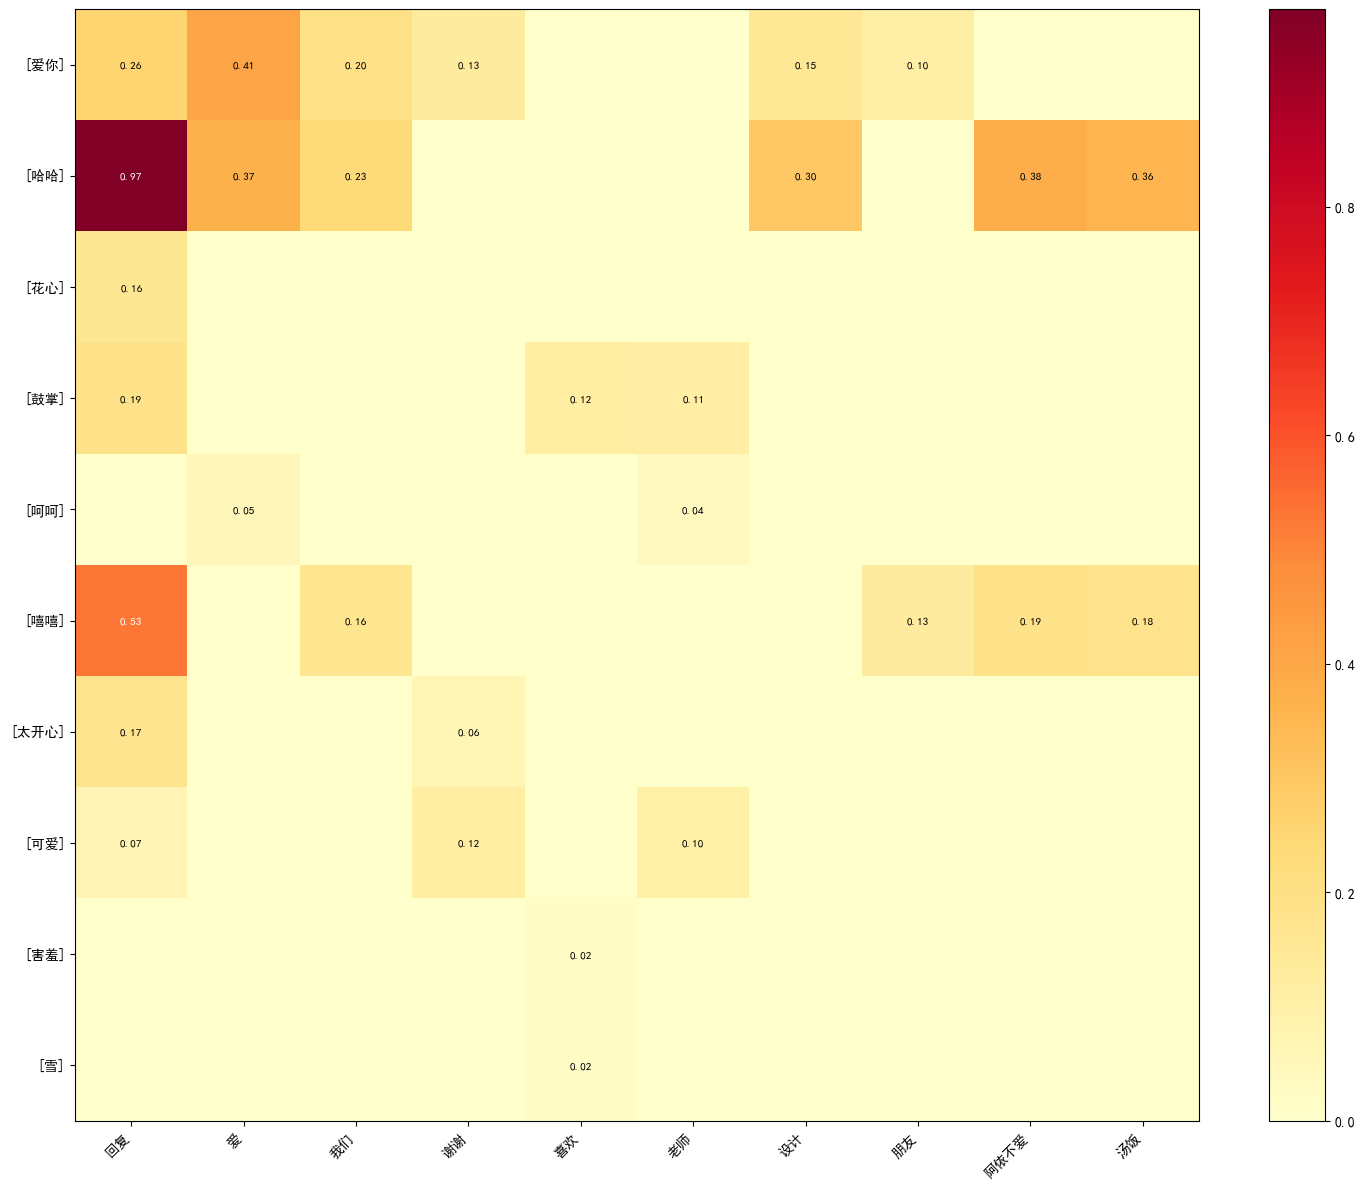

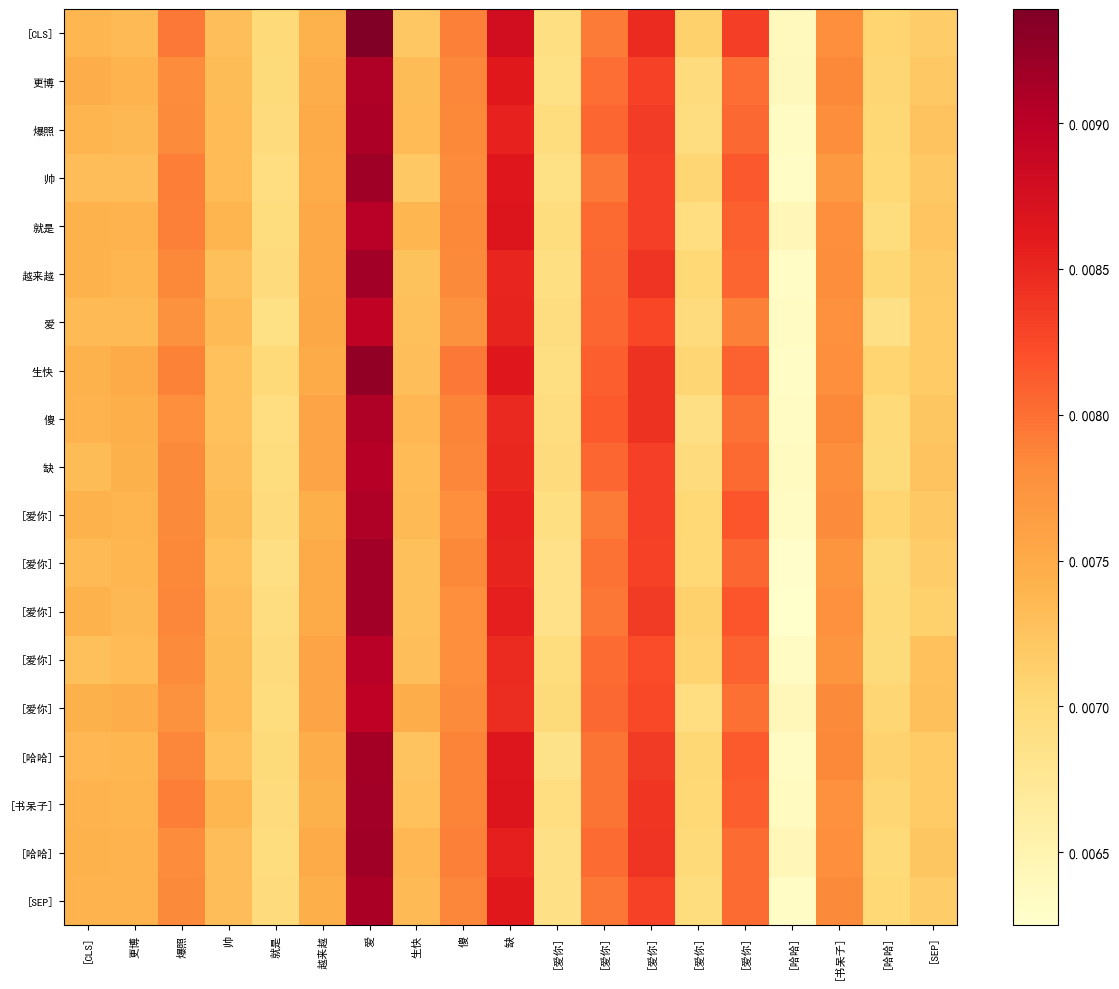

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import re
import json
import pickle
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import random
from typing import List, Dict, Tuple, Set
import os
import matplotlib

try:
    matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
    matplotlib.rcParams['axes.unicode_minus'] = False
except:
    pass

class LocalEmojiTokenizer:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.emoji2idx = {}
        self.idx2emoji = {}
        
        self.special_tokens = {
            '[PAD]': 0,
            '[UNK]': 1,
            '[CLS]': 2,
            '[SEP]': 3,
            '[MASK]': 4
        }
        
        for token, idx in self.special_tokens.items():
            self.word2idx[token] = idx
            self.idx2word[idx] = token
        
        self.next_word_idx = len(self.special_tokens)
        self.next_emoji_idx = 0
        
        self.chinese_punctuation = set('，。！？；：、（）《》「」')
        self.exclude_chars = set('/@#!$%^&*()_+-=<>?|\\~`[]{}"\';:.,')
        
    def normalize_emoji(self, emoji_text: str) -> str:
        emoji_text = emoji_text.replace("'", "").replace('"', '')
        
        while emoji_text.startswith('[') and emoji_text.count('[') > 1:
            emoji_text = emoji_text[1:]
        while emoji_text.endswith(']') and emoji_text.count(']') > 1:
            emoji_text = emoji_text[:-1]
        
        if emoji_text.startswith('[') and emoji_text.endswith(']'):
            content = emoji_text[1:-1]
            content = re.sub(r'\s+', '', content)
            content = ''.join([c for c in content if '\u4e00' <= c <= '\u9fff'])
            
            if content:
                return f'[{content}]'
        
        return '[UNK]'
    
    def extract_emojis_from_text(self, text: str) -> List[str]:
        emoji_positions = []
        
        pos = 0
        while pos < len(text):
            start = text.find('[', pos)
            if start == -1:
                break
            
            depth = 1
            end = start + 1
            while end < len(text) and depth > 0:
                if text[end] == '[':
                    depth += 1
                elif text[end] == ']':
                    depth -= 1
                end += 1
            
            if depth == 0:
                emoji = text[start:end]
                emoji_positions.append((start, end, emoji))
                pos = end
            else:
                pos = start + 1
        
        normalized_emojis = []
        for start, end, emoji in emoji_positions:
            normalized = self.normalize_emoji(emoji)
            if normalized != '[UNK]':
                normalized_emojis.append((start, end, normalized))
        
        return normalized_emojis
    
    def is_valid_chinese_word(self, word: str) -> bool:
        if not word:
            return False
        
        if not all('\u4e00' <= c <= '\u9fff' for c in word):
            return False
        
        if any(c in self.exclude_chars for c in word):
            return False
        
        if len(word) < 1:
            return False
        
        if len(word) == 1:
            emotion_chars = {
                '爱', '好', '美', '帅', '棒', '赞', '强', '乐', '笑', '喜', '欢',
                '傻', '缺', '冷', '累', '困', '烦', '坏', '差', '难', '哭', '苦',
                '恨', '怒', '悲', '伤', '痛', '甜', '暖', '热', '爽', '酷'
            }
            return word in emotion_chars
        
        return True
    
    def split_text_by_space(self, text: str) -> List[str]:
        parts = text.split()
        valid_words = []

        for part in parts:
            part_clean = part.strip()

            chinese_english_only = ''.join([c for c in part_clean 
                                           if '\u4e00' <= c <= '\u9fff'])

            if self.is_valid_chinese_word(chinese_english_only):
                valid_words.append(chinese_english_only)
        
        return valid_words
    
    def build_vocab(self, texts: List[str], min_freq: int = 3):
        all_emojis = Counter()
        all_words = Counter()
        
        for text in texts:
            emoji_positions = self.extract_emojis_from_text(text)
            for start, end, emoji in emoji_positions:
                all_emojis[emoji] += 1
            
            emoji_ranges = [(start, end) for start, end, _ in emoji_positions]
            emoji_ranges.sort(key=lambda x: x[0])
            
            last_end = 0
            for start, end in emoji_ranges:
                if start > last_end:
                    text_segment = text[last_end:start]
                    words = self.split_text_by_space(text_segment)
                    for word in words:
                        all_words[word] += 1
                last_end = end
            
            if last_end < len(text):
                text_segment = text[last_end:]
                words = self.split_text_by_space(text_segment)
                for word in words:
                    all_words[word] += 1
        
        emoji_list = all_emojis.most_common()
        
        for emoji, freq in emoji_list:
            normalized_emoji = self.normalize_emoji(emoji)
            
            if normalized_emoji != '[UNK]' and normalized_emoji not in self.emoji2idx:
                self.emoji2idx[normalized_emoji] = self.next_emoji_idx
                self.idx2emoji[self.next_emoji_idx] = normalized_emoji
                self.next_emoji_idx += 1
        
        frequent_words = [(word, freq) for word, freq in all_words.items() 
                         if freq >= min_freq and self.is_valid_chinese_word(word)]
        
        frequent_words.sort(key=lambda x: x[1], reverse=True)
        
        word_count = 0
        max_words = 1500
        
        for word, freq in frequent_words:
            if word not in self.word2idx:
                self.word2idx[word] = self.next_word_idx
                self.idx2word[self.next_word_idx] = word
                self.next_word_idx += 1
                word_count += 1
                if word_count >= max_words:
                    break
        
        self.word_vocab_size = len(self.word2idx)
        self.emoji_vocab_size = len(self.emoji2idx)
        self.vocab_size = self.word_vocab_size + self.emoji_vocab_size
        
        return self
    
    def tokenize(self, text: str) -> List[str]:
        tokens = []
        
        emoji_positions = self.extract_emojis_from_text(text)
        
        if not emoji_positions:
            words = self.split_text_by_space(text)
            return words
        
        last_end = 0
        
        for start, end, emoji in sorted(emoji_positions, key=lambda x: x[0]):
            if start > last_end:
                text_before = text[last_end:start]
                words = self.split_text_by_space(text_before)
                tokens.extend(words)
            
            if emoji in self.emoji2idx:
                tokens.append(emoji)
            else:
                renormalized = self.normalize_emoji(emoji)
                if renormalized in self.emoji2idx:
                    tokens.append(renormalized)
                else:
                    tokens.append('[UNK]')
            
            last_end = end
        
        if last_end < len(text):
            text_after = text[last_end:]
            words = self.split_text_by_space(text_after)
            tokens.extend(words)
        
        return tokens
    
    def convert_tokens_to_ids(self, tokens: List[str]) -> List[int]:
        ids = []
        
        for token in tokens:
            if token in self.emoji2idx:
                emoji_id = self.emoji2idx[token] + self.word_vocab_size
                ids.append(emoji_id)
            elif token in self.word2idx:
                ids.append(self.word2idx[token])
            else:
                ids.append(self.word2idx['[UNK]'])
        
        return ids
    
    def convert_ids_to_tokens(self, ids: List[int]) -> List[str]:
        tokens = []
        
        for idx in ids:
            if idx >= self.word_vocab_size:
                emoji_idx = idx - self.word_vocab_size
                if emoji_idx in self.idx2emoji:
                    tokens.append(self.idx2emoji[emoji_idx])
                else:
                    tokens.append('[UNK]')
            elif idx in self.idx2word:
                tokens.append(self.idx2word[idx])
            else:
                tokens.append('[UNK]')
        
        return tokens
    
    def save(self, path: str):
        data = {
            'word2idx': self.word2idx,
            'idx2word': self.idx2word,
            'emoji2idx': self.emoji2idx,
            'idx2emoji': self.idx2emoji,
            'vocab_size': self.vocab_size,
            'word_vocab_size': self.word_vocab_size,
            'emoji_vocab_size': self.emoji_vocab_size
        }
        
        with open(path, 'wb') as f:
            pickle.dump(data, f)
    
    def load(self, path: str):
        with open(path, 'rb') as f:
            data = pickle.load(f)
        
        self.word2idx = data['word2idx']
        self.idx2word = data['idx2word']
        self.emoji2idx = data['emoji2idx']
        self.idx2emoji = data['idx2emoji']
        self.vocab_size = data['vocab_size']
        self.word_vocab_size = data['word_vocab_size']
        self.emoji_vocab_size = data['emoji_vocab_size']
        
        return self

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, dropout: float = 0.1):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.attention_weights = None
    
    def forward(self, query, key, value, key_padding_mask=None, attn_mask=None, need_weights=True):
        batch_size = query.size(0)
        
        Q = self.q_proj(query)
        K = self.k_proj(key)
        V = self.v_proj(value)
        
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.head_dim)
        
        if key_padding_mask is not None:
            attn_scores = attn_scores.masked_fill(
                key_padding_mask.unsqueeze(1).unsqueeze(2),
                float('-inf')
            )
        
        if attn_mask is not None:
            attn_scores = attn_scores.masked_fill(attn_mask == 0, float('-inf'))
        
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        if need_weights:
            self.attention_weights = attn_weights.detach().cpu()
        
        attn_output = torch.matmul(attn_weights, V)
        attn_output = attn_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.embed_dim
        )
        
        attn_output = self.out_proj(attn_output)
        
        return attn_output, attn_weights

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout: float = 0.1):
        super(TransformerEncoderLayer, self).__init__()
        
        self.self_attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embed_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
    
    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        attn_output, attn_weights = self.self_attn(
            src, src, src,
            key_padding_mask=src_key_padding_mask,
            attn_mask=src_mask,
            need_weights=True
        )
        
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)
        
        ff_output = self.linear2(self.dropout2(F.relu(self.linear1(src))))
        src = src + self.dropout3(ff_output)
        src = self.norm2(src)
        
        return src, attn_weights

class LocalTransformer(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int = 128, num_layers: int = 3, 
                 num_heads: int = 4, ff_dim: int = 256, max_len: int = 128, 
                 num_classes: int = 2, dropout: float = 0.1):
        super(LocalTransformer, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.max_len = max_len
        
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(max_len, embed_dim)
        
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_classes)
        )
        
        self.dropout = nn.Dropout(dropout)
        self._init_weights()
    
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, input_ids, attention_mask=None, return_attention=False):
        batch_size, seq_len = input_ids.size()
        
        position_ids = torch.arange(seq_len, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand(batch_size, -1)
        
        token_embeds = self.token_embedding(input_ids)
        position_embeds = self.position_embedding(position_ids)
        
        embeddings = token_embeds + position_embeds
        embeddings = self.dropout(embeddings)
        
        if attention_mask is not None:
            key_padding_mask = (attention_mask == 0)
        else:
            key_padding_mask = None
        
        all_attention_weights = []
        hidden_states = embeddings
        
        for layer in self.layers:
            hidden_states, attn_weights = layer(
                hidden_states, 
                src_key_padding_mask=key_padding_mask
            )
            all_attention_weights.append(attn_weights)
        
        cls_output = hidden_states[:, 0, :]
        logits = self.classifier(cls_output)
        
        if return_attention:
            return logits, all_attention_weights
        else:
            return logits

class EmojiDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        tokens = self.tokenizer.tokenize(text)
        tokens = ['[CLS]'] + tokens[:self.max_len-2] + ['[SEP]']
        
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        
        if len(input_ids) < self.max_len:
            padding = [self.tokenizer.word2idx['[PAD]']] * (self.max_len - len(input_ids))
            input_ids = input_ids + padding
        else:
            input_ids = input_ids[:self.max_len]
        
        attention_mask = [1 if token_id != self.tokenizer.word2idx['[PAD]'] else 0 
                         for token_id in input_ids]
        
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

def preprocess_emoji_data():
    with open('emoji.txt', 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]
    
    temp_tokenizer = LocalEmojiTokenizer()
    processed_lines = []
    
    for line in lines:
        emoji_positions = temp_tokenizer.extract_emojis_from_text(line)
        
        new_line_chars = list(line)
        offset = 0
        
        for start, end, emoji in sorted(emoji_positions, key=lambda x: x[0]):
            adj_start = start + offset
            adj_end = end + offset
            
            new_line_chars[adj_start:adj_end] = list(emoji)
            offset += len(emoji) - (adj_end - adj_start)
        
        processed_line = ''.join(new_line_chars)
        processed_lines.append(processed_line)
    
    with open('emoji_processed.txt', 'w', encoding='utf-8') as f:
        for line in processed_lines:
            f.write(line + '\n')
    
    return processed_lines

def prepare_data():
    if os.path.exists('emoji_processed.txt'):
        with open('emoji_processed.txt', 'r', encoding='utf-8') as f:
            lines = [line.strip() for line in f if line.strip()]
    else:
        with open('emoji.txt', 'r', encoding='utf-8') as f:
            lines = [line.strip() for line in f if line.strip()]
    
    texts = []
    labels = []
    
    positive_keywords = {'爱', '开心', '高兴', '喜欢', '帅', '好', '美', '赞', '棒', '强', 
                        '笑', '乐', '幸福', '快乐', '可爱', '漂亮', '帅气', '优秀'}
    negative_keywords = {'傻', '缺', '冷', '累', '困', '烦', '讨厌', '坏', '差', '难', 
                        '哭', '苦', '伤心', '痛苦', '糟糕', '失败', '难过'}
    
    tokenizer = LocalEmojiTokenizer()
    
    for line in lines:
        texts.append(line)
        
        tokens = tokenizer.tokenize(line)
        words_only = [t for t in tokens if not t.startswith('[') and not t.endswith(']')]
        
        pos_count = sum(1 for word in words_only if word in positive_keywords)
        neg_count = sum(1 for word in words_only if word in negative_keywords)
        
        if pos_count > neg_count:
            labels.append(1)
        elif neg_count > pos_count:
            labels.append(0)
        else:
            labels.append(random.randint(0, 1))
    
    return texts, labels

class NeuronAnalyzer:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.model.eval()
    
    def analyze_sentence(self, sentence: str):
        tokens = self.tokenizer.tokenize(sentence)
        full_tokens = ['[CLS]'] + tokens + ['[SEP]']
        
        input_ids = self.tokenizer.convert_tokens_to_ids(full_tokens)
        
        if len(input_ids) < 128:
            input_ids = input_ids + [self.tokenizer.word2idx['[PAD]']] * (128 - len(input_ids))
        else:
            input_ids = input_ids[:128]
        
        input_tensor = torch.tensor([input_ids], dtype=torch.long)
        attention_mask = torch.ones_like(input_tensor)
        
        with torch.no_grad():
            outputs, all_attention_weights = self.model(
                input_tensor, attention_mask, return_attention=True
            )
        
        last_layer_attn = all_attention_weights[-1]
        avg_attention = last_layer_attn.mean(dim=1)[0]
        
        return {
            'tokens': full_tokens,
            'attention_matrix': avg_attention.numpy(),
            'predictions': torch.softmax(outputs[0], dim=0).numpy()
        }
    
    def analyze_emoji_neurons(self, sentences: List[str]):
        emoji_results = defaultdict(lambda: {
            'word_associations': Counter(),
            'emoji_associations': Counter(),
            'attention_scores': []
        })
        
        processed_count = 0
        for sentence in sentences:
            analysis = self.analyze_sentence(sentence)
            tokens = analysis['tokens']
            attention_matrix = analysis['attention_matrix']
            
            emoji_indices = []
            for i, token in enumerate(tokens):
                if token in self.tokenizer.emoji2idx:
                    emoji_indices.append((i, token))
            
            for emoji_idx, emoji_token in emoji_indices:
                attention_to_others = attention_matrix[emoji_idx]
                
                for target_idx, target_token in enumerate(tokens):
                    if target_idx == emoji_idx:
                        continue
                    
                    attention_score = attention_to_others[target_idx]
                    
                    if target_token in self.tokenizer.emoji2idx:
                        emoji_results[emoji_token]['emoji_associations'][target_token] += attention_score
                    elif target_token not in ['[CLS]', '[SEP]', '[PAD]']:
                        if self.tokenizer.is_valid_chinese_word(target_token):
                            emoji_results[emoji_token]['word_associations'][target_token] += attention_score
            
            processed_count += 1
        
        summary = {}
        for emoji, results in emoji_results.items():
            valid_words = {word: score for word, score in results['word_associations'].items() 
                          if self.tokenizer.is_valid_chinese_word(word)}
            top_words = sorted(valid_words.items(), key=lambda x: x[1], reverse=True)[:10]
            
            top_emojis = results['emoji_associations'].most_common(3)
            
            summary[emoji] = {
                'top_words': [(word, score) for word, score in top_words],
                'top_emojis': [(emoji, score) for emoji, score in top_emojis]
            }
        
        return summary
    
    def generate_top_emoji_word_matrix(self, summary: Dict, top_k_emojis: int = 10, top_k_words: int = 10):
        if not summary:
            return None, None, None
        
        emoji_counts = Counter()
        for emoji, data in summary.items():
            if data['top_words']:
                emoji_counts[emoji] = len(data['top_words'])
        
        top_emojis = [emoji for emoji, _ in emoji_counts.most_common(top_k_emojis)]
        
        if not top_emojis:
            return None, None, None
        
        word_counts = Counter()
        for emoji in top_emojis:
            if emoji in summary:
                for word, score in summary[emoji]['top_words']:
                    word_counts[word] += 1
        
        top_words = [word for word, _ in word_counts.most_common(top_k_words)]
        
        if not top_words:
            return None, None, None
        
        association_matrix = np.zeros((len(top_emojis), len(top_words)))
        
        for i, emoji in enumerate(top_emojis):
            if emoji in summary:
                word_scores = {word: score for word, score in summary[emoji]['top_words']}
                for j, word in enumerate(top_words):
                    if word in word_scores:
                        association_matrix[i, j] = word_scores[word]
        
        return top_emojis, top_words, association_matrix
    
    def visualize_emoji_word_matrix(self, top_emojis: List[str], top_words: List[str], 
                                  association_matrix: np.ndarray, 
                                  save_path: str = 'emoji_word_heatmap.png'):
        if association_matrix is None or len(top_emojis) == 0 or len(top_words) == 0:
            return
        
        fig, ax = plt.subplots(figsize=(15, 12))
        
        im = ax.imshow(association_matrix, cmap='YlOrRd', aspect='auto')
        
        ax.set_xticks(np.arange(len(top_words)))
        ax.set_yticks(np.arange(len(top_emojis)))
        ax.set_xticklabels(top_words, rotation=45, fontsize=10, ha='right')
        ax.set_yticklabels(top_emojis, fontsize=10)
        
        plt.colorbar(im, ax=ax)
        
        for i in range(len(top_emojis)):
            for j in range(len(top_words)):
                if association_matrix[i, j] > 0:
                    text = ax.text(j, i, f'{association_matrix[i, j]:.2f}',
                                 ha="center", va="center", 
                                 color="black" if association_matrix[i, j] < np.max(association_matrix)/2 else "white",
                                 fontsize=8)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
    
    def visualize_attention(self, sentence: str, save_path: str = 'attention_heatmap.png'):
        analysis = self.analyze_sentence(sentence)
        tokens = analysis['tokens']
        attention_matrix = analysis['attention_matrix']
        
        non_pad_indices = [i for i, token in enumerate(tokens) if token != '[PAD]']
        if len(non_pad_indices) == 0:
            return
        
        max_tokens = min(30, len(non_pad_indices))
        indices = non_pad_indices[:max_tokens]
        
        attention_matrix = attention_matrix[np.ix_(indices, indices)]
        display_tokens = [tokens[i] for i in indices]
        
        fig, ax = plt.subplots(figsize=(12, 10))
        im = ax.imshow(attention_matrix, cmap='YlOrRd', aspect='auto')
        
        ax.set_xticks(np.arange(len(display_tokens)))
        ax.set_yticks(np.arange(len(display_tokens)))
        ax.set_xticklabels(display_tokens, rotation=90, fontsize=8)
        ax.set_yticklabels(display_tokens, fontsize=8)
        
        plt.colorbar(im, ax=ax)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
    
    def generate_emoji_report(self, summary: Dict):
        if not summary:
            return
        
        sorted_emojis = sorted(summary.items(), 
                              key=lambda x: len(x[1]['top_words']), 
                              reverse=True)
        
        display_count = min(15, len(sorted_emojis))
        
        report_data = {}
        for emoji, data in summary.items():
            report_data[emoji] = {
                'top_words': [{'word': w, 'score': float(s)} for w, s in data['top_words'][:10]],
                'top_emojis': [{'emoji': e, 'score': float(s)} for e, s in data['top_emojis']]
            }
        
        with open('neuron_analysis_report.json', 'w', encoding='utf-8') as f:
            json.dump(report_data, f, ensure_ascii=False, indent=2)

def train_model():
    preprocess_emoji_data()
    texts, labels = prepare_data()
    
    tokenizer = LocalEmojiTokenizer()
    tokenizer.build_vocab(texts, min_freq=3)
    
    model = LocalTransformer(
        vocab_size=tokenizer.vocab_size,
        embed_dim=128,
        num_layers=3,
        num_heads=4,
        ff_dim=256,
        max_len=128,
        num_classes=2,
        dropout=0.1
    )
    
    dataset = EmojiDataset(texts, labels, tokenizer)
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=16, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=16, shuffle=False
    )
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    num_epochs = 10
    best_val_acc = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_tensor = batch['label'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels_tensor)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels_tensor.size(0)
            correct += (predicted == labels_tensor).sum().item()
        
        train_acc = correct / total
        
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels_tensor = batch['label'].to(device)
                
                outputs = model(input_ids, attention_mask)
                _, predicted = torch.max(outputs, 1)
                
                val_total += labels_tensor.size(0)
                val_correct += (predicted == labels_tensor).sum().item()
        
        val_acc = val_correct / val_total
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'tokenizer': tokenizer,
                'epoch': epoch,
                'val_acc': val_acc
            }, 'local_emoji_model.pth')
            tokenizer.save('local_tokenizer.pkl')
    
    return model, tokenizer

def main():
    if os.path.exists('local_emoji_model.pth') and os.path.exists('local_tokenizer.pkl'):
        choice = input("Input 'y' to retrain, other key to load existing model: ")
        
        if choice.lower() == 'y':
            model, tokenizer = train_model()
        else:
            tokenizer = LocalEmojiTokenizer()
            tokenizer.load('local_tokenizer.pkl')
            
            checkpoint = torch.load('local_emoji_model.pth', map_location='cpu')
            
            model = LocalTransformer(
                vocab_size=tokenizer.vocab_size,
                embed_dim=128,
                num_layers=3,
                num_heads=4,
                ff_dim=256,
                max_len=128,
                num_classes=2,
                dropout=0.1
            )
            model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model, tokenizer = train_model()
    
    if os.path.exists('emoji_processed.txt'):
        with open('emoji_processed.txt', 'r', encoding='utf-8') as f:
            all_sentences = [line.strip() for line in f if line.strip()]
    else:
        with open('emoji.txt', 'r', encoding='utf-8') as f:
            all_sentences = [line.strip() for line in f if line.strip()]
    
    test_sentences = []
    for sentence in all_sentences:
        emojis = tokenizer.extract_emojis_from_text(sentence)
        if len(emojis) > 0:
            test_sentences.append(sentence)
    
    if len(test_sentences) < 20:
        random_indices = random.sample(range(len(all_sentences)), min(50, len(all_sentences)))
        for idx in random_indices:
            if all_sentences[idx] not in test_sentences:
                test_sentences.append(all_sentences[idx])
    
    test_sentences = test_sentences[:150]
    
    if len(test_sentences) == 0:
        return
    
    analyzer = NeuronAnalyzer(model, tokenizer)
    
    summary = analyzer.analyze_emoji_neurons(test_sentences)
    
    analyzer.generate_emoji_report(summary)
    
    top_emojis, top_words, association_matrix = analyzer.generate_top_emoji_word_matrix(
        summary, top_k_emojis=10, top_k_words=10
    )
    
    if top_emojis and top_words and association_matrix is not None:
        analyzer.visualize_emoji_word_matrix(
            top_emojis, top_words, association_matrix, 
            'emoji_word_heatmap.png'
        )
    
    if test_sentences:
        example_sentence = None
        for sentence in test_sentences:
            emojis = tokenizer.extract_emojis_from_text(sentence)
            if len(emojis) >= 2:
                example_sentence = sentence
                break
        
        if example_sentence is None:
            example_sentence = test_sentences[0]
        
        analyzer.visualize_attention(example_sentence, 'single_sentence_attention.png')
    
    return model, tokenizer

if __name__ == "__main__":
    model, tokenizer = main()

In [8]:
##### import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

try:
    model
    tokenizer
except NameError:
    print("Error: model and tokenizer not found. Running main analysis code first...")
    
    try:
        import pickle
        import torch
        
        print("Loading existing model...")
        tokenizer = LocalEmojiTokenizer()
        tokenizer.load('local_tokenizer.pkl')
        
        checkpoint = torch.load('local_emoji_model.pth', map_location='cpu')
        
        model = LocalTransformer(
            vocab_size=tokenizer.vocab_size,
            embed_dim=128,
            num_layers=3,
            num_heads=4,
            ff_dim=256,
            max_len=128,
            num_classes=2,
            dropout=0.1
        )
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        print("Model loaded successfully!")
    except Exception as e:
        print(f"Model loading failed: {e}")
        print("Please run the main analysis code first.")

analyzer = NeuronAnalyzer(model, tokenizer)

try:
    with open('emoji_processed.txt', 'r', encoding='utf-8') as f:
        all_sentences = [line.strip() for line in f if line.strip()]
except:
    with open('emoji.txt', 'r', encoding='utf-8') as f:
        all_sentences = [line.strip() for line in f if line.strip()]

print(f"Total sentences loaded: {len(all_sentences)}")

def visualize_sentence_attention(sentence_idx, max_display_tokens=30):
    if sentence_idx < 0 or sentence_idx >= len(all_sentences):
        print(f"Error: Sentence index should be between 0 and {len(all_sentences)-1}")
        return
    
    sentence = all_sentences[sentence_idx]
    print(f"\n{'='*60}")
    print(f"Sentence #{sentence_idx}: {sentence}")
    print(f"{'='*60}")
    
    tokens = tokenizer.tokenize(sentence)
    print(f"Tokenized result ({len(tokens)} tokens):")
    for i, token in enumerate(tokens):
        if token.startswith('[') and token.endswith(']'):
            print(f"  [{i:2d}] {token:10s} ← Emoji")
        else:
            print(f"  [{i:2d}] {token:10s}")
    
    try:
        analysis = analyzer.analyze_sentence(sentence)
        full_tokens = analysis['tokens']
        attention_matrix = analysis['attention_matrix']
        
        non_pad_indices = [i for i, token in enumerate(full_tokens) if token != '[PAD]']
        if len(non_pad_indices) == 0:
            print("No valid tokens to display")
            return
        
        display_count = min(max_display_tokens, len(non_pad_indices))
        indices = non_pad_indices[:display_count]
        
        attention_matrix = attention_matrix[np.ix_(indices, indices)]
        display_tokens = [full_tokens[i] for i in indices]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        im1 = ax1.imshow(attention_matrix, cmap='YlOrRd', aspect='auto')
        ax1.set_title(f"Attention Heatmap (Sentence #{sentence_idx})", fontsize=14)
        ax1.set_xlabel("Target token", fontsize=12)
        ax1.set_ylabel("Source token", fontsize=12)
        
        ax1.set_xticks(np.arange(len(display_tokens)))
        ax1.set_yticks(np.arange(len(display_tokens)))
        ax1.set_xticklabels(display_tokens, rotation=90, fontsize=8)
        ax1.set_yticklabels(display_tokens, fontsize=8)
        
        plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
        
        emoji_indices = [i for i, token in enumerate(display_tokens) 
                        if token.startswith('[') and token.endswith(']')]
        
        if emoji_indices:
            emoji_attention = attention_matrix[np.ix_(emoji_indices, np.arange(len(display_tokens)))]
            
            im2 = ax2.imshow(emoji_attention, cmap='YlOrRd', aspect='auto')
            ax2.set_title("Emoji Attention (Emoji attention to other tokens)", fontsize=14)
            ax2.set_xlabel("All tokens", fontsize=12)
            ax2.set_ylabel("Emoji", fontsize=12)
            
            ax2.set_xticks(np.arange(len(display_tokens)))
            ax2.set_yticks(np.arange(len(emoji_indices)))
            ax2.set_xticklabels(display_tokens, rotation=90, fontsize=8)
            ax2.set_yticklabels([display_tokens[i] for i in emoji_indices], fontsize=8)
            
            plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
            
            print(f"\nEmoji attention analysis:")
            for i, emoji_idx in enumerate(emoji_indices):
                emoji_token = display_tokens[emoji_idx]
                attention_scores = emoji_attention[i]
                
                word_scores = []
                for j, token in enumerate(display_tokens):
                    if j not in emoji_indices and token not in ['[CLS]', '[SEP]', '[PAD]']:
                        word_scores.append((token, attention_scores[j]))
                
                word_scores.sort(key=lambda x: x[1], reverse=True)
                
                print(f"\n  {emoji_token} most attentive words:")
                for word, score in word_scores[:5]:
                    print(f"    {word}: {score:.4f}")
        else:
            ax2.text(0.5, 0.5, "No Emoji in this sentence", 
                    ha='center', va='center', fontsize=14, transform=ax2.transAxes)
            ax2.set_title("No Emoji", fontsize=14)
            ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        predictions = analysis['predictions']
        sentiment = "Positive" if predictions[1] > predictions[0] else "Negative"
        confidence = max(predictions)
        
        print(f"\nSentiment prediction: {sentiment} (Confidence: {confidence:.2%})")
        print(f"Positive probability: {predictions[1]:.2%}, Negative probability: {predictions[0]:.2%}")
        
    except Exception as e:
        print(f"Error analyzing sentence: {e}")

def find_sentences_with_emoji(emoji_text=None, keyword=None, limit=10):
    results = []
    
    for idx, sentence in enumerate(all_sentences):
        if emoji_text:
            emojis = tokenizer.extract_emojis_from_text(sentence)
            emojis = [e[2] for e in emojis]
            
            if emoji_text in emojis:
                results.append((idx, sentence))
        
        elif keyword and keyword in sentence:
            results.append((idx, sentence))
        
        if len(results) >= limit:
            break
    
    return results

def search_and_visualize(emoji_text=None, keyword=None):
    if not emoji_text and not keyword:
        print("Please specify emoji or keyword to search")
        return
    
    if emoji_text:
        print(f"\nSearching for sentences containing {emoji_text}...")
        results = find_sentences_with_emoji(emoji_text=emoji_text, limit=5)
    else:
        print(f"\nSearching for sentences containing '{keyword}'...")
        results = find_sentences_with_emoji(keyword=keyword, limit=5)
    
    if not results:
        print("No related sentences found")
        return
    
    print(f"Found {len(results)} related sentences:")
    for idx, (sentence_idx, sentence) in enumerate(results, 1):
        print(f"\n{idx}. Sentence #{sentence_idx}:")
        print(f"   {sentence[:100]}...")
    
    try:
        choice = int(input(f"\nEnter the sentence number to view (1-{len(results)}), or 0 to skip: "))
        if 1 <= choice <= len(results):
            sentence_idx, _ = results[choice-1]
            visualize_sentence_attention(sentence_idx)
    except:
        print("Invalid input, skipping...")

def interactive_neuron_viewer():
    print("="*70)
    print("Interactive Emoji Neuron Visualization Tool")
    print("="*70)
    print("\nAvailable commands:")
    print("  1. Enter sentence number (0-{}) to view neuron map".format(len(all_sentences)-1))
    print("  2. Enter 'e:emoji' to search sentences with specific emoji (e.g.: e:[哈哈])")
    print("  3. Enter 'k:keyword' to search sentences with keyword (e.g.: k:happy)")
    print("  4. Enter 'r' to randomly select a sentence")
    print("  5. Enter 'l' to list first 20 sentences")
    print("  6. Enter 's' to show statistics")
    print("  7. Enter 'q' to quit")
    print("="*70)
    
    while True:
        try:
            user_input = input("\nEnter command or sentence number: ").strip()
            
            if user_input.lower() == 'q':
                print("Exiting interactive viewer")
                break
            
            elif user_input.lower() == 'r':
                import random
                random_idx = random.randint(0, len(all_sentences)-1)
                visualize_sentence_attention(random_idx)
            
            elif user_input.lower() == 'l':
                print("\nFirst 20 sentences:")
                for i in range(min(20, len(all_sentences))):
                    print(f"{i:3d}. {all_sentences[i][:80]}...")
            
            elif user_input.lower() == 's':
                print(f"\nDataset statistics:")
                print(f"  Total sentences: {len(all_sentences)}")
                
                emoji_count = 0
                emoji_types = set()
                for sentence in all_sentences:
                    emojis = tokenizer.extract_emojis_from_text(sentence)
                    if emojis:
                        emoji_count += 1
                        for _, _, emoji in emojis:
                            emoji_types.add(emoji)
                
                print(f"  Sentences with emoji: {emoji_count} ({emoji_count/len(all_sentences):.1%})")
                print(f"  Different emoji types: {len(emoji_types)}")
                
                emoji_counter = Counter()
                for sentence in all_sentences:
                    emojis = tokenizer.extract_emojis_from_text(sentence)
                    for _, _, emoji in emojis:
                        emoji_counter[emoji] += 1
                
                print(f"\nTop 5 most frequent Emojis:")
                for emoji, count in emoji_counter.most_common(5):
                    print(f"  {emoji}: {count} times")
            
            elif user_input.startswith('e:'):
                emoji_text = user_input[2:].strip()
                if not emoji_text.startswith('[') or not emoji_text.endswith(']'):
                    emoji_text = f'[{emoji_text}]'
                
                search_and_visualize(emoji_text=emoji_text)
            
            elif user_input.startswith('k:'):
                keyword = user_input[2:].strip()
                search_and_visualize(keyword=keyword)
            
            else:
                try:
                    sentence_idx = int(user_input)
                    if 0 <= sentence_idx < len(all_sentences):
                        visualize_sentence_attention(sentence_idx)
                    else:
                        print(f"Error: Sentence number should be between 0 and {len(all_sentences)-1}")
                except ValueError:
                    print("Invalid input! Please refer to command format above")
        
        except KeyboardInterrupt:
            print("\nUser interrupt, exiting...")
            break
        except Exception as e:
            print(f"Error occurred: {e}")

def quick_view(sentence_idx=None):
    if sentence_idx is None:
        import random
        sentence_idx = random.randint(0, len(all_sentences)-1)
    
    visualize_sentence_attention(sentence_idx)
    return sentence_idx

def batch_view(start_idx=0, count=5):
    for i in range(start_idx, min(start_idx + count, len(all_sentences))):
        visualize_sentence_attention(i)
        if i < start_idx + count - 1:
            print("\n" + "="*70 + "\n")

print("\n" + "="*70)
print("Interactive tool is ready!")
print("="*70)
print("\nQuick usage:")
print("  1. Use quick_view(42) to view neuron map of sentence #42")
print("  2. Use quick_view() to randomly view a sentence")
print("  3. Use batch_view(0, 3) to batch view first 3 sentences")
print("  4. Use interactive_neuron_viewer() to enter interactive mode")

auto_start = input("\nAuto start interactive mode? (y/n): ").strip().lower()
if auto_start == 'y':
    interactive_neuron_viewer()
else:
    print("\nYou can call these functions anytime:")
    print("  interactive_neuron_viewer() - Start interactive mode")
    print("  quick_view(0) - View sentence #0")
    print("  search_and_visualize(emoji_text='[哈哈]') - Search sentences with [哈哈]")

Total sentences loaded: 1050

Interactive tool is ready!

Quick usage:
  1. Use quick_view(42) to view neuron map of sentence #42
  2. Use quick_view() to randomly view a sentence
  3. Use batch_view(0, 3) to batch view first 3 sentences
  4. Use interactive_neuron_viewer() to enter interactive mode



Auto start interactive mode? (y/n):  y


Interactive Emoji Neuron Visualization Tool

Available commands:
  1. Enter sentence number (0-1049) to view neuron map
  2. Enter 'e:emoji' to search sentences with specific emoji (e.g.: e:[哈哈])
  3. Enter 'k:keyword' to search sentences with keyword (e.g.: k:happy)
  4. Enter 'r' to randomly select a sentence
  5. Enter 'l' to list first 20 sentences
  6. Enter 's' to show statistics
  7. Enter 'q' to quit



Enter command or sentence number:  q


Exiting interactive viewer


In [9]:
import torch
import pickle
import json
from typing import Dict, List, Tuple, Set
from collections import defaultdict, Counter
import numpy as np
import os
import sys
from datetime import datetime

print("Library imports completed")

import torch.nn as nn
import torch.nn.functional as F

class LocalEmojiTokenizer:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.emoji2idx = {}
        self.idx2emoji = {}
        self.word_vocab_size = 0
        self.emoji_vocab_size = 0
        self.vocab_size = 0
    
    def load(self, path: str):
        with open(path, 'rb') as f:
            data = pickle.load(f)
        
        self.word2idx = data['word2idx']
        self.idx2word = data['idx2word']
        self.emoji2idx = data['emoji2idx']
        self.idx2emoji = data['idx2emoji']
        self.vocab_size = data['vocab_size']
        self.word_vocab_size = data['word_vocab_size']
        self.emoji_vocab_size = data['emoji_vocab_size']
        
        print(f"Tokenizer loaded from {path}")
        print(f"Vocabulary size: {self.vocab_size} (Words: {self.word_vocab_size}, Emoji: {self.emoji_vocab_size})")
        return self
    
    def tokenize(self, text: str) -> List[str]:
        tokens = []
        words = text.split()
        for word in words:
            if word.startswith('[') and word.endswith(']'):
                tokens.append(word)
            elif word in self.word2idx:
                tokens.append(word)
        return tokens
    
    def is_valid_chinese_word(self, word: str) -> bool:
        if not word:
            return False
        return word in self.word2idx

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, dropout: float = 0.1):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.attention_weights = None
    
    def forward(self, query, key, value, key_padding_mask=None, attn_mask=None, need_weights=True):
        batch_size = query.size(0)
        
        Q = self.q_proj(query)
        K = self.k_proj(key)
        V = self.v_proj(value)
        
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.head_dim)
        
        if key_padding_mask is not None:
            attn_scores = attn_scores.masked_fill(
                key_padding_mask.unsqueeze(1).unsqueeze(2),
                float('-inf')
            )
        
        if attn_mask is not None:
            attn_scores = attn_scores.masked_fill(attn_mask == 0, float('-inf'))
        
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        if need_weights:
            self.attention_weights = attn_weights.detach().cpu()
        
        attn_output = torch.matmul(attn_weights, V)
        attn_output = attn_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.embed_dim
        )
        
        attn_output = self.out_proj(attn_output)
        
        return attn_output, attn_weights

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout: float = 0.1):
        super(TransformerEncoderLayer, self).__init__()
        
        self.self_attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embed_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
    
    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        attn_output, attn_weights = self.self_attn(
            src, src, src,
            key_padding_mask=src_key_padding_mask,
            attn_mask=src_mask,
            need_weights=True
        )
        
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)
        
        ff_output = self.linear2(self.dropout2(F.relu(self.linear1(src))))
        src = src + self.dropout3(ff_output)
        src = self.norm2(src)
        
        return src, attn_weights

class LocalTransformer(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int = 128, num_layers: int = 3, 
                 num_heads: int = 4, ff_dim: int = 256, max_len: int = 128, 
                 num_classes: int = 2, dropout: float = 0.1):
        super(LocalTransformer, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.max_len = max_len
        
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(max_len, embed_dim)
        
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim // 2, num_classes)
        )
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input_ids, attention_mask=None, return_attention=False):
        batch_size, seq_len = input_ids.size()
        
        position_ids = torch.arange(seq_len, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand(batch_size, -1)
        
        token_embeds = self.token_embedding(input_ids)
        position_embeds = self.position_embedding(position_ids)
        
        embeddings = token_embeds + position_embeds
        embeddings = self.dropout(embeddings)
        
        if attention_mask is not None:
            key_padding_mask = (attention_mask == 0)
        else:
            key_padding_mask = None
        
        all_attention_weights = []
        hidden_states = embeddings
        
        for layer in self.layers:
            hidden_states, attn_weights = layer(
                hidden_states, 
                src_key_padding_mask=key_padding_mask
            )
            all_attention_weights.append(attn_weights)
        
        cls_output = hidden_states[:, 0, :]
        logits = self.classifier(cls_output)
        
        if return_attention:
            return logits, all_attention_weights
        else:
            return logits

print("Model class definitions completed")

def load_model_and_tokenizer():
    print("=" * 80)
    print("Loading model and tokenizer...")
    print("=" * 80)
    
    if not os.path.exists('local_tokenizer.pkl'):
        print("Error: Tokenizer file 'local_tokenizer.pkl' not found")
        return None, None
    
    if not os.path.exists('local_emoji_model.pth'):
        print("Error: Model file 'local_emoji_model.pth' not found")
        return None, None
    
    try:
        tokenizer = LocalEmojiTokenizer()
        tokenizer.load('local_tokenizer.pkl')
        
        model = LocalTransformer(
            vocab_size=tokenizer.vocab_size,
            embed_dim=128,
            num_layers=3,
            num_heads=4,
            ff_dim=256,
            max_len=128,
            num_classes=2,
            dropout=0.1
        )
        
        checkpoint = torch.load('local_emoji_model.pth', 
                               map_location='cpu',
                               weights_only=False)
        
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        print(f"Model loaded successfully")
        print(f"Validation accuracy: {checkpoint['val_acc']:.4f}")
        print(f"Vocabulary size: {tokenizer.vocab_size} (Words: {tokenizer.word_vocab_size}, Emoji: {tokenizer.emoji_vocab_size})")
        
        return model, tokenizer
        
    except Exception as e:
        print(f"Error during loading: {str(e)}")
        return None, None

print("Loading model...")
model, tokenizer = load_model_and_tokenizer()

if model is None or tokenizer is None:
    print("\nPlease ensure the following files exist:")
    print("  1. local_emoji_model.pth")
    print("  2. local_tokenizer.pkl")
    print("  3. emoji.txt or emoji_processed.txt")
else:
    print("\nModel loaded successfully!")

class CommonContentAnalyzer:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.model.eval()
        print("Analyzer initialized")
    
    def analyze_sentence(self, sentence: str):
        tokens = []
        words = sentence.split()
        for word in words:
            if word.startswith('[') and word.endswith(']'):
                clean_word = word.replace("'", "").replace('"', '')
                while clean_word.startswith('[') and clean_word.count('[') > 1:
                    clean_word = clean_word[1:]
                while clean_word.endswith(']') and clean_word.count(']') > 1:
                    clean_word = clean_word[:-1]
                if clean_word.startswith('[') and clean_word.endswith(']'):
                    tokens.append(clean_word)
            elif word in self.tokenizer.word2idx:
                tokens.append(word)
        
        full_tokens = ['[CLS]'] + tokens + ['[SEP]']
        
        input_ids = []
        for token in full_tokens:
            if token in self.tokenizer.emoji2idx:
                emoji_id = self.tokenizer.emoji2idx[token] + self.tokenizer.word_vocab_size
                input_ids.append(emoji_id)
            elif token in self.tokenizer.word2idx:
                input_ids.append(self.tokenizer.word2idx[token])
            else:
                input_ids.append(self.tokenizer.word2idx['[UNK]'])
        
        if len(input_ids) < 128:
            input_ids = input_ids + [self.tokenizer.word2idx['[PAD]']] * (128 - len(input_ids))
        else:
            input_ids = input_ids[:128]
        
        input_tensor = torch.tensor([input_ids], dtype=torch.long)
        attention_mask = torch.ones_like(input_tensor)
        
        with torch.no_grad():
            outputs, all_attention_weights = self.model(
                input_tensor, attention_mask, return_attention=True
            )
        
        last_layer_attn = all_attention_weights[-1]
        avg_attention = last_layer_attn.mean(dim=1)[0]
        
        return {
            'tokens': full_tokens,
            'attention_matrix': avg_attention.numpy(),
            'predictions': torch.softmax(outputs[0], dim=0).numpy()
        }
    
    def find_common_content_pairs(self) -> List[Tuple[str, str]]:
        print("\n" + "=" * 80)
        print("Finding common content pairs...")
        print("=" * 80)
        
        common_pairs = []
        
        all_words = set()
        for idx, word in self.tokenizer.idx2word.items():
            if idx >= 5:
                all_words.add(word)
        
        all_emoji_contents = set()
        for idx, emoji in self.tokenizer.idx2emoji.items():
            if emoji.startswith('[') and emoji.endswith(']'):
                emoji_content = emoji[1:-1]
                emoji_content = emoji_content.strip()
                all_emoji_contents.add(emoji_content)
        
        common_contents = all_words.intersection(all_emoji_contents)
        
        for content in common_contents:
            word = content
            emoji = f'[{content}]'
            common_pairs.append((word, emoji))
        
        print(f"Found {len(common_pairs)} common content pairs")
        
        if common_pairs:
            for i, (word, emoji) in enumerate(common_pairs[:20], 1):
                print(f"  {i:3d}. Word: '{word:10s}' <-> Emoji: {emoji}")
            if len(common_pairs) > 20:
                print(f"  ... and {len(common_pairs) - 20} more pairs")
        else:
            print("  No common content pairs found")
        
        return common_pairs
    
    def analyze_word_associations(self, sentences: List[str], target_word: str) -> Dict[str, float]:
        from collections import Counter
        
        word_associations = Counter()
        analyzed_count = 0
        
        print(f"  Analyzing word '{target_word}' associations...")
        
        max_sentences = min(100, len(sentences))
        sentences_to_analyze = sentences[:max_sentences]
        
        for sentence_idx, sentence in enumerate(sentences_to_analyze):
            try:
                analysis = self.analyze_sentence(sentence)
                tokens = analysis['tokens']
                attention_matrix = analysis['attention_matrix']
                
                target_indices = [i for i, token in enumerate(tokens) if token == target_word]
                
                for target_idx in target_indices:
                    attention_to_others = attention_matrix[target_idx]
                    
                    for other_idx, other_token in enumerate(tokens):
                        if other_idx == target_idx:
                            continue
                        
                        if (other_token not in ['[CLS]', '[SEP]', '[PAD]', '[UNK]'] and 
                            other_token in self.tokenizer.word2idx):
                            
                            attention_score = attention_to_others[other_idx]
                            word_associations[other_token] += attention_score
                
                analyzed_count += 1
                if analyzed_count % 20 == 0:
                    print(f"    Analyzed {analyzed_count}/{max_sentences} sentences")
                    
            except Exception as e:
                continue
        
        print(f"  Analysis completed, processed {analyzed_count} sentences")
        
        top_associations = dict(word_associations.most_common(10))
        
        return top_associations
    
    def analyze_emoji_associations(self, sentences: List[str], target_emoji: str) -> Dict[str, float]:
        from collections import Counter
        
        emoji_associations = Counter()
        analyzed_count = 0
        
        print(f"  Analyzing emoji {target_emoji} associations...")
        
        max_sentences = min(100, len(sentences))
        sentences_to_analyze = sentences[:max_sentences]
        
        for sentence in sentences_to_analyze:
            try:
                analysis = self.analyze_sentence(sentence)
                tokens = analysis['tokens']
                attention_matrix = analysis['attention_matrix']
                
                target_indices = [i for i, token in enumerate(tokens) if token == target_emoji]
                
                for target_idx in target_indices:
                    attention_to_others = attention_matrix[target_idx]
                    
                    for other_idx, other_token in enumerate(tokens):
                        if other_idx == target_idx:
                            continue
                        
                        if (other_token not in ['[CLS]', '[SEP]', '[PAD]', '[UNK]'] and 
                            other_token in self.tokenizer.word2idx):
                            
                            attention_score = attention_to_others[other_idx]
                            emoji_associations[other_token] += attention_score
                
                analyzed_count += 1
                if analyzed_count % 20 == 0:
                    print(f"    Analyzed {analyzed_count}/{max_sentences} sentences")
                    
            except Exception as e:
                continue
        
        print(f"  Analysis completed, processed {analyzed_count} sentences")
        
        top_associations = dict(emoji_associations.most_common(10))
        
        return top_associations
    
    def get_relevant_sentences(self, all_sentences: List[str], target_content: str, is_emoji: bool = False) -> List[str]:
        relevant_sentences = []
        
        print(f"  Finding sentences containing {'emoji' if is_emoji else 'word'} '{target_content}'...")
        
        for sentence in all_sentences:
            if is_emoji:
                if target_content in sentence:
                    relevant_sentences.append(sentence)
            else:
                if target_content in sentence:
                    relevant_sentences.append(sentence)
        
        print(f"  Found {len(relevant_sentences)} relevant sentences")
        return relevant_sentences
    
    def compare_common_content_pairs(self, all_sentences: List[str], common_pairs: List[Tuple[str, str]]) -> Dict:
        print("\n" + "=" * 80)
        print("Comparing common content pairs...")
        print("=" * 80)
        
        comparison_results = {}
        total_pairs = len(common_pairs)
        
        for pair_idx, (word, emoji) in enumerate(common_pairs, 1):
            print(f"\n[{pair_idx}/{total_pairs}] Analyzing common content: '{word}' / {emoji}")
            print("-" * 60)
            
            word_sentences = self.get_relevant_sentences(all_sentences, word, is_emoji=False)
            emoji_sentences = self.get_relevant_sentences(all_sentences, emoji, is_emoji=True)
            
            if len(word_sentences) == 0 and len(emoji_sentences) == 0:
                print(f"  No sentences found containing this content, skipping")
                continue
            elif len(word_sentences) < 3 and len(emoji_sentences) < 3:
                print(f"  Too few sentences (word:{len(word_sentences)}, emoji:{len(emoji_sentences)}), skipping")
                continue
            
            print(f"  Word sentences: {len(word_sentences)}, Emoji sentences: {len(emoji_sentences)}")
            
            word_top10 = {}
            if len(word_sentences) >= 3:
                word_top10 = self.analyze_word_associations(word_sentences, word)
            else:
                print(f"  Too few word sentences, skipping word analysis")
            
            emoji_top10 = {}
            if len(emoji_sentences) >= 3:
                emoji_top10 = self.analyze_emoji_associations(emoji_sentences, emoji)
            else:
                print(f"  Too few emoji sentences, skipping emoji analysis")
            
            if not word_top10 and not emoji_top10:
                print(f"  No associations found, skipping")
                continue
            
            all_associations = {}
            for w, score in word_top10.items():
                all_associations[w] = {'word_score': score, 'emoji_score': 0.0}
            for w, score in emoji_top10.items():
                if w in all_associations:
                    all_associations[w]['emoji_score'] = score
                else:
                    all_associations[w] = {'word_score': 0.0, 'emoji_score': score}
            
            sorted_associations = []
            for w, scores in all_associations.items():
                avg_score = (scores['word_score'] + scores['emoji_score']) / 2
                sorted_associations.append((w, scores['word_score'], scores['emoji_score'], avg_score))
            
            sorted_associations.sort(key=lambda x: x[3], reverse=True)
            top20_associations = sorted_associations[:20]
            
            comparison_results[(word, emoji)] = {
                'word': word,
                'emoji': emoji,
                'word_sentence_count': len(word_sentences),
                'emoji_sentence_count': len(emoji_sentences),
                'word_top10': word_top10,
                'emoji_top10': emoji_top10,
                'top20_combined': [
                    {
                        'word': w,
                        'word_association_score': float(word_score),
                        'emoji_association_score': float(emoji_score),
                        'average_score': float(avg_score)
                    }
                    for w, word_score, emoji_score, avg_score in top20_associations
                ]
            }
            
            if word_top10:
                print(f"  Top5 associations for word '{word}':")
                for idx, (w, score) in enumerate(list(word_top10.items())[:5], 1):
                    print(f"      {idx}. {w:8s}: {score:.4f}")
            
            if emoji_top10:
                print(f"  Top5 associations for emoji {emoji}:")
                for idx, (w, score) in enumerate(list(emoji_top10.items())[:5], 1):
                    print(f"      {idx}. {w:8s}: {score:.4f}")
            
            if top20_associations:
                print(f"  Combined top5 associations:")
                for idx, (w, ws, es, avg) in enumerate(top20_associations[:5], 1):
                    print(f"      {idx}. {w:8s} | Word: {ws:.4f} | Emoji: {es:.4f} | Avg: {avg:.4f}")
        
        print(f"\nAnalysis completed! Successfully analyzed {len(comparison_results)}/{len(common_pairs)} common content pairs")
        return comparison_results

print("Analyzer class defined")

if model and tokenizer:
    analyzer = CommonContentAnalyzer(model, tokenizer)
    print("Analyzer created successfully!")
else:
    print("Unable to create analyzer, please ensure model loaded successfully")

def load_data():
    print("\n" + "=" * 80)
    print("Loading data files...")
    print("=" * 80)
    
    data_files = ['emoji_processed.txt', 'emoji.txt']
    data_file = None
    
    for file in data_files:
        if os.path.exists(file):
            data_file = file
            print(f"Found data file: {file}")
            break
    
    if not data_file:
        print("Error: No data file found")
        return None
    
    try:
        with open(data_file, 'r', encoding='utf-8') as f:
            all_sentences = [line.strip() for line in f if line.strip()]
        
        print(f"Loaded {len(all_sentences)} sentences from '{data_file}'")
        
        return all_sentences
        
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

print("\nLoading data...")
all_sentences = load_data()

common_pairs = []

if all_sentences and model and tokenizer:
    print("\n" + "=" * 80)
    print("Step 1: Finding common content pairs")
    print("=" * 80)
    
    common_pairs = analyzer.find_common_content_pairs()
    
    if not common_pairs:
        print("\nNo common content pairs found!")
else:
    print("Unable to perform common content analysis, please ensure data and model loaded")

if all_sentences and common_pairs:
    print("\n" + "=" * 80)
    print("Step 2: Comparing common content pairs")
    print("=" * 80)
    
    if len(common_pairs) > 10:
        print(f"Found {len(common_pairs)} common content pairs, suggest analyzing first 10")
        print("Choose:")
        print("  1. Analyze first 10 pairs (fast)")
        print("  2. Analyze all pairs (slow)")
        print("  3. Analyze specific number")
        
        try:
            choice = int(input("Choose (1-3): "))
            if choice == 1:
                common_pairs_to_analyze = common_pairs[:10]
                print(f"Will analyze first 10 common content pairs...")
            elif choice == 2:
                common_pairs_to_analyze = common_pairs
                print(f"Will analyze all {len(common_pairs)} common content pairs...")
            elif choice == 3:
                n = int(input("Enter number to analyze: "))
                common_pairs_to_analyze = common_pairs[:min(n, len(common_pairs))]
                print(f"Will analyze first {len(common_pairs_to_analyze)} common content pairs...")
            else:
                print("Invalid choice, default to first 10 pairs")
                common_pairs_to_analyze = common_pairs[:10]
        except:
            print("Invalid input, default to first 10 pairs")
            common_pairs_to_analyze = common_pairs[:10]
    else:
        common_pairs_to_analyze = common_pairs
    
    print(f"Will analyze {len(common_pairs_to_analyze)} common content pairs...")
    
    comparison_results = analyzer.compare_common_content_pairs(
        all_sentences, 
        common_pairs_to_analyze
    )
    
    if comparison_results:
        print(f"\nAnalysis completed, obtained {len(comparison_results)} valid results")
    else:
        print("\nNo analysis results obtained")
else:
    print("Unable to perform comparison analysis, please ensure common content pairs and data")

def generate_reports(comparison_results):
    if not comparison_results:
        print("No analysis results to generate report")
        return None
    
    print("\n" + "=" * 80)
    print("Step 3: Generating analysis reports")
    print("=" * 80)
    
    report_data = {
        'analysis_time': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'total_pairs_analyzed': len(comparison_results),
        'pairs': []
    }
    
    for (word, emoji), data in comparison_results.items():
        pair_data = {
            'word': data['word'],
            'emoji': data['emoji'],
            'statistics': {
                'word_sentence_count': data['word_sentence_count'],
                'emoji_sentence_count': data['emoji_sentence_count']
            },
            'word_top10_associations': [
                {'word': w, 'score': float(score)}
                for w, score in data['word_top10'].items()
            ],
            'emoji_top10_associations': [
                {'word': w, 'score': float(score)}
                for w, score in data['emoji_top10'].items()
            ],
            'top20_combined_associations': data['top20_combined']
        }
        report_data['pairs'].append(pair_data)
    
    json_file = 'common_content_comparison_report.json'
    try:
        with open(json_file, 'w', encoding='utf-8') as f:
            json.dump(report_data, f, ensure_ascii=False, indent=2)
        print(f"JSON report saved: {json_file}")
    except Exception as e:
        print(f"Error saving JSON report: {str(e)}")
    
    txt_file = 'common_content_summary.txt'
    try:
        with open(txt_file, 'w', encoding='utf-8') as f:
            f.write("=" * 80 + "\n")
            f.write("Emoji-Word Common Content Analysis Report\n")
            f.write("=" * 80 + "\n\n")
            
            f.write(f"Analysis time: {report_data['analysis_time']}\n")
            f.write(f"Total common content pairs analyzed: {report_data['total_pairs_analyzed']}\n\n")
            
            f.write("=" * 80 + "\n")
            f.write("Detailed Analysis Results\n")
            f.write("=" * 80 + "\n\n")
            
            for i, pair_data in enumerate(report_data['pairs'], 1):
                f.write(f"{i}. Common content: Word '{pair_data['word']}' <-> Emoji {pair_data['emoji']}\n")
                f.write(f"   Statistics: Word appears in {pair_data['statistics']['word_sentence_count']} sentences, ")
                f.write(f"Emoji appears in {pair_data['statistics']['emoji_sentence_count']} sentences\n")
                
                f.write(f"   Word top10 associations:\n")
                for j, assoc in enumerate(pair_data['word_top10_associations'], 1):
                    f.write(f"      {j:2d}. {assoc['word']:8s}: {assoc['score']:.4f}\n")
                
                f.write(f"   Emoji top10 associations:\n")
                for j, assoc in enumerate(pair_data['emoji_top10_associations'], 1):
                    f.write(f"      {j:2d}. {assoc['word']:8s}: {assoc['score']:.4f}\n")
                
                f.write(f"   Combined top20 associations (sorted by average score):\n")
                for j, assoc in enumerate(pair_data['top20_combined_associations'], 1):
                    f.write(f"      {j:2d}. {assoc['word']:8s} | Word association: {assoc['word_association_score']:.4f} | ")
                    f.write(f"Emoji association: {assoc['emoji_association_score']:.4f} | ")
                    f.write(f"Average: {assoc['average_score']:.4f}\n")
                
                f.write("\n" + "-" * 80 + "\n\n")
        
        print(f"Text report saved: {txt_file}")
        
    except Exception as e:
        print(f"Error saving text report: {str(e)}")
    
    print("\n" + "=" * 80)
    print("Analysis Summary")
    print("=" * 80)
    
    print(f"Successfully analyzed {len(comparison_results)} common content pairs")
    
    total_word_sentences = sum(d['word_sentence_count'] for d in comparison_results.values())
    total_emoji_sentences = sum(d['emoji_sentence_count'] for d in comparison_results.values())
    
    avg_word_sentences = total_word_sentences / len(comparison_results)
    avg_emoji_sentences = total_emoji_sentences / len(comparison_results)
    
    print(f"Average word-containing sentences: {avg_word_sentences:.1f}")
    print(f"Average emoji-containing sentences: {avg_emoji_sentences:.1f}")
    
    if comparison_results:
        top_pairs = sorted(comparison_results.items(), 
                          key=lambda x: (x[1]['word_sentence_count'] + x[1]['emoji_sentence_count']), 
                          reverse=True)[:3]
        
        print(f"\nMost representative common content pairs:")
        for (word, emoji), data in top_pairs:
            total_sentences = data['word_sentence_count'] + data['emoji_sentence_count']
            print(f"   '{word}'/{emoji}: {total_sentences} sentences (word:{data['word_sentence_count']}, emoji:{data['emoji_sentence_count']})")
    
    return report_data

if 'comparison_results' in locals() and comparison_results:
    report_data = generate_reports(comparison_results)
else:
    print("\nNo analysis results to generate report")

print("\n" + "=" * 80)
print("Analysis completed!")
print("=" * 80)

files_created = []
if os.path.exists('common_content_comparison_report.json'):
    files_created.append('common_content_comparison_report.json')
if os.path.exists('common_content_summary.txt'):
    files_created.append('common_content_summary.txt')

if files_created:
    print("Generated files:")
    for file in files_created:
        print(f"  ✓ {file}")
else:
    print("No report files generated")

print("=" * 80)

if 'common_pairs' in locals():
    print(f"Number of common content pairs found: {len(common_pairs)}")

if 'comparison_results' in locals():
    print(f"Number of pairs successfully analyzed: {len(comparison_results)}")

print("\nYou can use the following variables for further analysis:")
print("  - common_pairs: All found common content pairs")
print("  - comparison_results: Analysis results (if available)")
print("  - report_data: Report data (if available)")
print("=" * 80)

Library imports completed
Model class definitions completed
Loading model...
Loading model and tokenizer...
Tokenizer loaded from local_tokenizer.pkl
Vocabulary size: 1475 (Words: 1271, Emoji: 204)
Model loaded successfully
Validation accuracy: 0.6476
Vocabulary size: 1475 (Words: 1271, Emoji: 204)

Model loaded successfully!
Analyzer class defined
Analyzer initialized
Analyzer created successfully!

Loading data...

Loading data files...
Found data file: emoji_processed.txt
Loaded 1050 sentences from 'emoji_processed.txt'

Step 1: Finding common content pairs

Finding common content pairs...
Found 35 common content pairs
    1. Word: '推荐        ' <-> Emoji: [推荐]
    2. Word: '神马        ' <-> Emoji: [神马]
    3. Word: '熊猫        ' <-> Emoji: [熊猫]
    4. Word: '阳光        ' <-> Emoji: [阳光]
    5. Word: '看看        ' <-> Emoji: [看看]
    6. Word: '吃货        ' <-> Emoji: [吃货]
    7. Word: '话筒        ' <-> Emoji: [话筒]
    8. Word: '呵呵        ' <-> Emoji: [呵呵]
    9. Word: '威武        ' <-> Emoj

Choose (1-3):  2


Will analyze all 35 common content pairs...
Will analyze 35 common content pairs...

Comparing common content pairs...

[1/35] Analyzing common content: '推荐' / [推荐]
------------------------------------------------------------
  Finding sentences containing word '推荐'...
  Found 16 relevant sentences
  Finding sentences containing emoji '[推荐]'...
  Found 4 relevant sentences
  Word sentences: 16, Emoji sentences: 4
  Analyzing word '推荐' associations...
  Analysis completed, processed 16 sentences
  Analyzing emoji [推荐] associations...
  Analysis completed, processed 4 sentences
  Top5 associations for word '推荐':
      1. 可以      : 0.0387
      2. 雅高      : 0.0317
      3. 酒店      : 0.0314
      4. 设计      : 0.0234
      5. 欢迎      : 0.0221
  Top5 associations for emoji [推荐]:
      1. 山药      : 0.0996
      2. 七洲      : 0.0653
      3. 吐鲁番     : 0.0652
      4. 没有      : 0.0389
      5. 蛀牙      : 0.0343
  Combined top5 associations:
      1. 山药       | Word: 0.0000 | Emoji: 0.0996 | Avg: 

Emoji Position Analysis - Scatter Plot Version


Select analysis mode:
1. Full analysis (requires model and tokenizer)
2. Simplified analysis (uses existing data)
Enter choice (1/2):  1


Emoji Position Analysis System - Scatter Plot Version
Emoji Position Analysis System - Scatter Plot Version
Analyzer initialization failed
Attempting simplified analysis using existing data...

Running simplified analysis...
Loaded neuron analysis report, contains 101 emojis

Top 5 Emojis (based on associated words count):
   1. [Love_You]      Associated Words: 10
   2. [Haha]          Associated Words: 10
   3. [Heart_Eyes]    Associated Words: 10
   4. [Clap]          Associated Words: 10
   5. [Hehe]          Associated Words: 10

Creating simplified scatter plots...


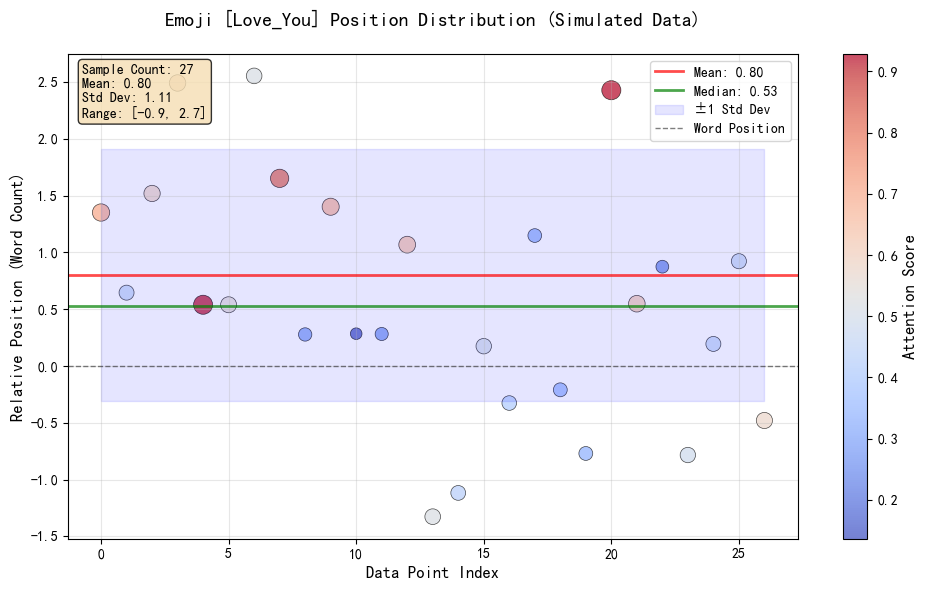

Scatter plot saved as 'simplified_scatter_1_Love_You.png'


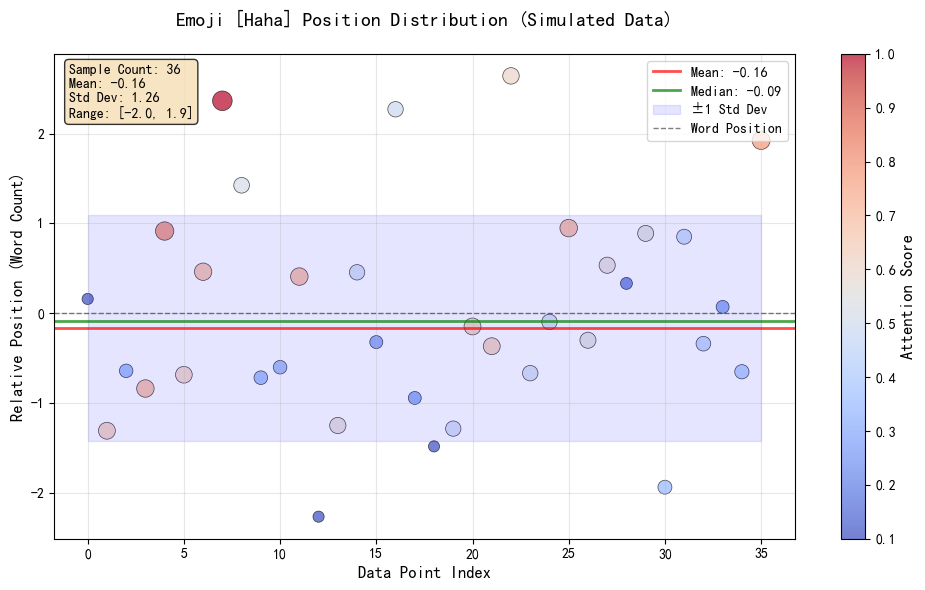

Scatter plot saved as 'simplified_scatter_2_Haha.png'


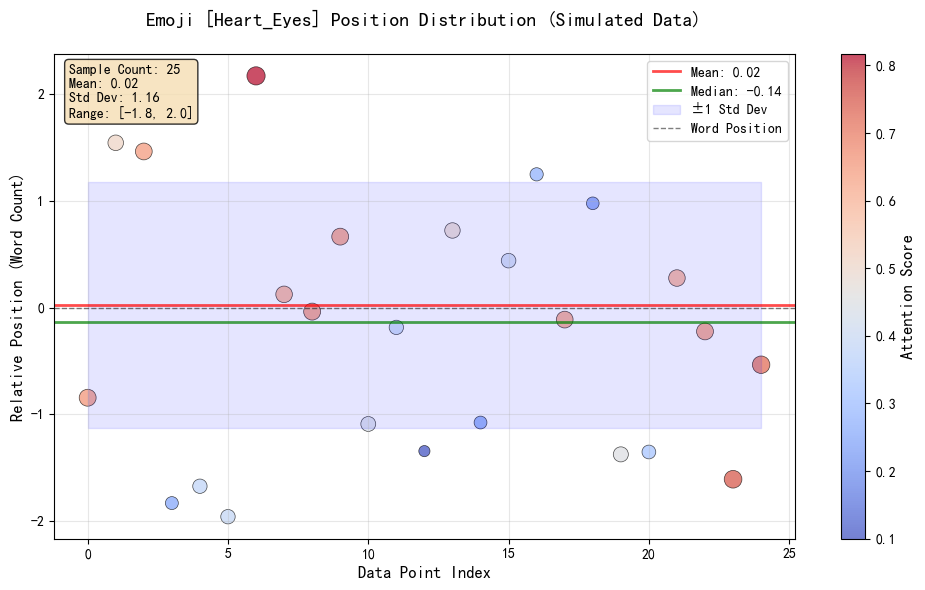

Scatter plot saved as 'simplified_scatter_3_Heart_Eyes.png'


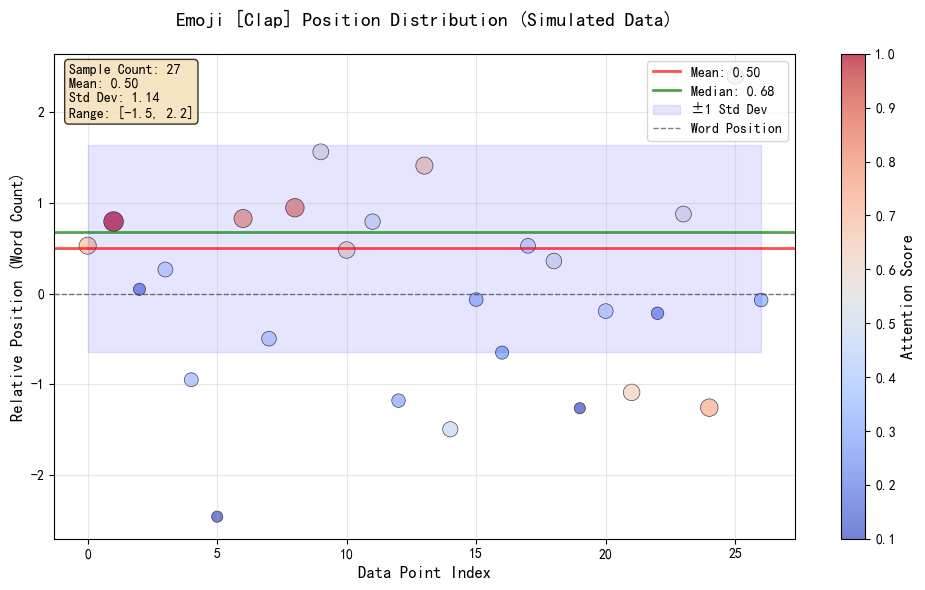

Scatter plot saved as 'simplified_scatter_4_Clap.png'


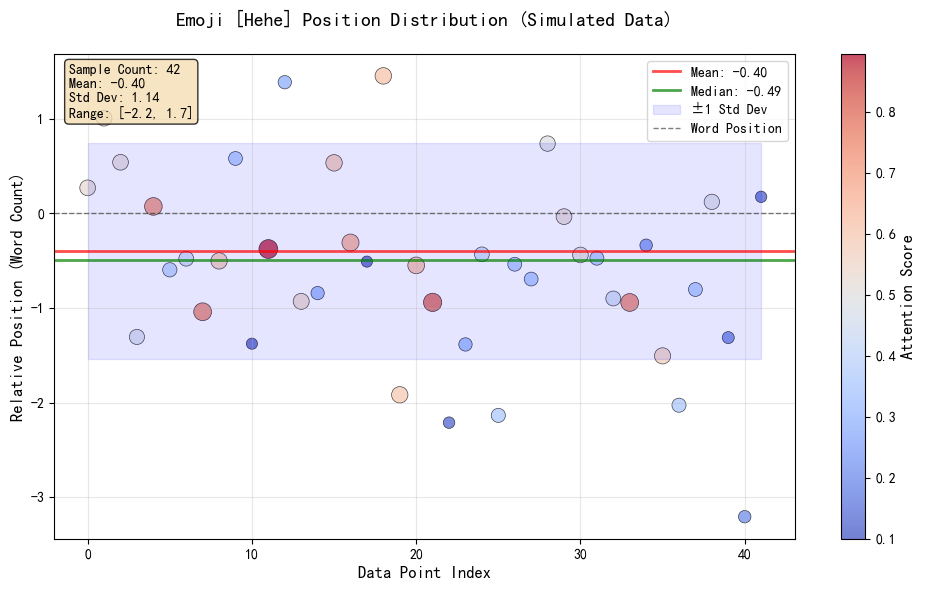

Scatter plot saved as 'simplified_scatter_5_Hehe.png'


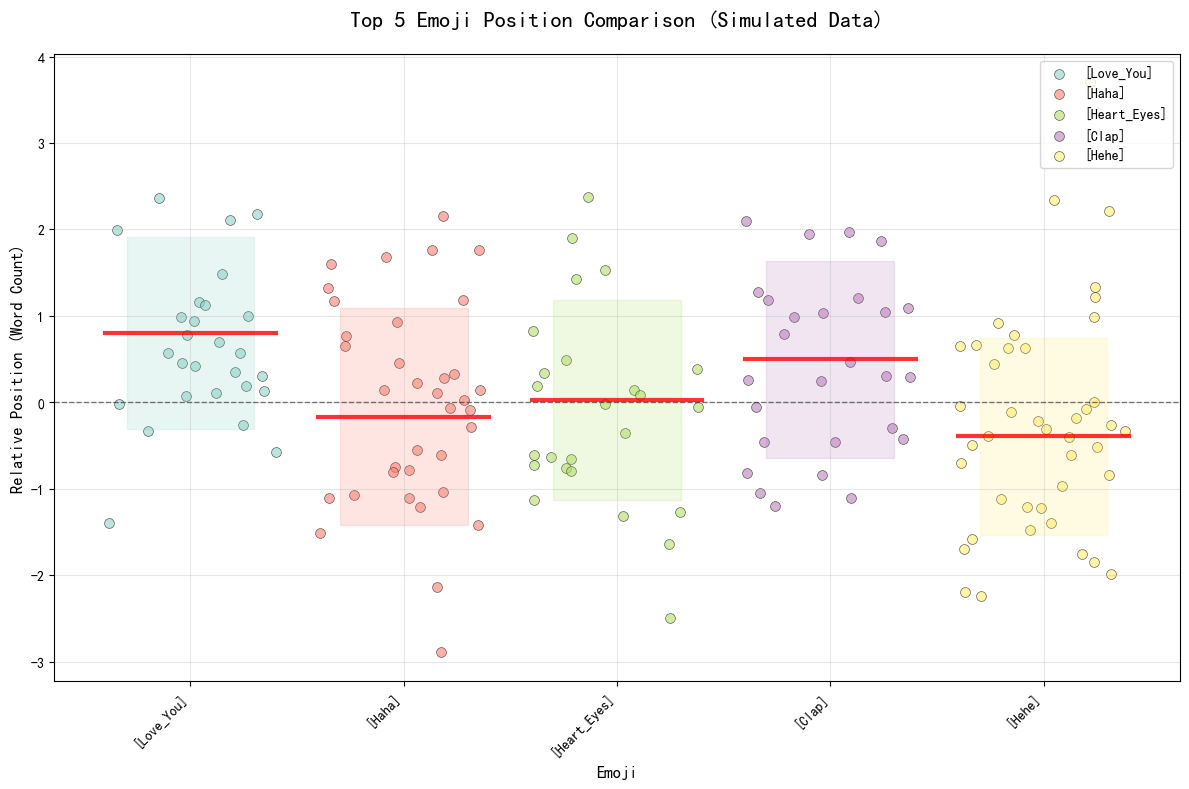

Comparison plot saved as 'simplified_comparison_scatter.png'


In [10]:
import torch
import pickle
import json
from typing import Dict, List, Tuple
from collections import defaultdict
import numpy as np
import os
import matplotlib.pyplot as plt

class EmojiPositionAnalyzerScatter:
    def __init__(self):
        self.model = None
        self.tokenizer = None
        self.neuron_data = None
        self.position_stats = defaultdict(list)
        
        print("=" * 80)
        print("Emoji Position Analysis System - Scatter Plot Version")
        print("=" * 80)
        
        self.load_resources()
    
    def load_resources(self):
        pass
    
    def translate_emoji_to_english(self, emoji: str) -> str:
        """Translate Chinese emoji to English description"""
        emoji_translations = {
            '[爱你]': '[Love_You]',
            '[哈哈]': '[Haha]',
            '[花心]': '[Heart_Eyes]',
            '[伤心]': '[Sad]',
            '[鼓掌]': '[Clap]',
            '[呵呵]': '[Hehe]',
            '[太开心]': '[Very_Happy]',
            '[嘻嘻]': '[Xixi]',
            '[笑cry]': '[Laugh_Cry]',
            '[喵喵]': '[Meow]',
            '[good]': '[Good]',
            '[可怜]': '[Poor]',
            '[馋嘴]': '[Drool]',
            '[色]': '[Desire]',
            '[亲亲]': '[Kiss]',
            '[挖鼻]': '[Nose_Pick]',
            '[泪]': '[Tears]',
            '[失望]': '[Disappointed]',
            '[思考]': '[Thinking]',
            '[怒]': '[Angry]',
            '[困]': '[Sleepy]',
            '[奥特曼]': '[Ultraman]',
            '[飞机]': '[Airplane]',
            '[月亮]': '[Moon]',
            '[太阳]': '[Sun]',
            '[星星]': '[Star]',
            '[心]': '[Heart]'
        }
        
        if emoji in emoji_translations:
            return emoji_translations[emoji]
        
        try:
            chinese_text = emoji.replace('[', '').replace(']', '')
            if chinese_text:
                return f'[{chinese_text}_EMOJI]'
        except:
            pass
        
        return emoji
    
    def visualize_position_scatter_plots(self, position_summary: Dict, top_emojis: List[str], 
                                       save_path_prefix: str = 'emoji_position_scatter'):
        if not top_emojis:
            print("No emoji data to plot")
            return
        
        print(f"\nCreating emoji position scatter plots...")
        
        try:
            for i, emoji in enumerate(top_emojis):
                if emoji not in self.position_stats:
                    print(f"Emoji {emoji} has no position data")
                    continue
                
                positions = self.position_stats[emoji]
                if len(positions) < 5:
                    print(f"Emoji {emoji} has insufficient data points ({len(positions)} points)")
                    continue
                
                fig, axes = plt.subplots(1, 2, figsize=(16, 6))
                
                ax1 = axes[0]
                
                rel_positions = [p['relative_position'] for p in positions]
                attention_scores = [p['attention_score'] for p in positions]
                sentence_lengths = [p['sentence_length'] for p in positions]
                
                x_indices = list(range(len(positions)))
                
                sizes = [50 + score * 200 for score in attention_scores]
                colors = attention_scores
                
                scatter = ax1.scatter(x_indices, rel_positions, 
                                     c=colors, s=sizes, 
                                     cmap='viridis', alpha=0.7,
                                     edgecolors='black', linewidth=0.5)
                
                cbar = plt.colorbar(scatter, ax=ax1)
                cbar.set_label('Attention Score', fontsize=12)
                
                emoji_english = self.translate_emoji_to_english(emoji)
                ax1.set_title(f'Emoji {emoji_english} Relative Position Distribution', fontsize=14, pad=20)
                ax1.set_xlabel('Data Point Index', fontsize=12)
                ax1.set_ylabel('Relative Position (Word Count)', fontsize=12)
                ax1.grid(True, alpha=0.3)
                ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
                
                mean_pos = np.mean(rel_positions)
                median_pos = np.median(rel_positions)
                std_pos = np.std(rel_positions)
                
                ax1.axhline(y=mean_pos, color='blue', linestyle='-', alpha=0.5, label=f'Mean: {mean_pos:.2f}')
                ax1.axhline(y=median_pos, color='green', linestyle='-', alpha=0.5, label=f'Median: {median_pos:.2f}')
                
                ax1.fill_between(x_indices, 
                                mean_pos - std_pos, 
                                mean_pos + std_pos, 
                                alpha=0.1, color='blue', label=f'±1 Std Dev')
                
                ax1.legend(loc='upper right')
                
                ax2 = axes[1]
                
                scatter2 = ax2.scatter(sentence_lengths, rel_positions,
                                      c=colors, s=sizes,
                                      cmap='plasma', alpha=0.7,
                                      edgecolors='black', linewidth=0.5)
                
                if len(sentence_lengths) > 1:
                    try:
                        z = np.polyfit(sentence_lengths, rel_positions, 1)
                        p = np.poly1d(z)
                        ax2.plot(sorted(sentence_lengths), p(sorted(sentence_lengths)), 
                                "r--", alpha=0.8, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
                    except:
                        pass
                
                ax2.set_title(f'Emoji {emoji_english} Position vs Sentence Length', fontsize=14, pad=20)
                ax2.set_xlabel('Sentence Length (Word Count)', fontsize=12)
                ax2.set_ylabel('Relative Position (Word Count)', fontsize=12)
                ax2.grid(True, alpha=0.3)
                ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
                
                q25 = np.percentile(rel_positions, 25)
                q75 = np.percentile(rel_positions, 75)
                ax2.axhline(y=q25, color='orange', linestyle=':', alpha=0.5, label=f'25%: {q25:.1f}')
                ax2.axhline(y=q75, color='orange', linestyle=':', alpha=0.5, label=f'75%: {q75:.1f}')
                
                ax2.legend(loc='upper right')
                
                plt.suptitle(f'Emoji {emoji_english} Position Analysis (Total {len(positions)} Samples)', 
                           fontsize=16, y=1.02)
                plt.tight_layout()
                
                emoji_name = emoji.replace('[', '').replace(']', '')
                emoji_english_name = emoji_english.replace('[', '').replace(']', '')
                save_file = f'{save_path_prefix}_{i+1}_{emoji_english_name}.png'
                plt.savefig(save_file, dpi=150, bbox_inches='tight')
                plt.show()
                
                print(f"Scatter plot saved as '{save_file}'")
                
                print(f"\nEmoji {emoji_english} Statistical Summary:")
                print(f"  Sample Count: {len(positions)}")
                print(f"  Relative Position - Mean: {mean_pos:.2f}, Median: {median_pos:.2f}, Std Dev: {std_pos:.2f}")
                print(f"  Relative Position Range: [{min(rel_positions):.1f}, {max(rel_positions):.1f}]")
                print(f"  Attention Score - Mean: {np.mean(attention_scores):.4f}, Range: [{min(attention_scores):.4f}, {max(attention_scores):.4f}]")
            
            print(f"\nCreating comprehensive comparison plot...")
            self.create_comparison_scatter_plot(position_summary, top_emojis, 'emoji_comparison_scatter.png')
            
        except Exception as e:
            print(f"Error creating scatter plots: {str(e)}")
    
    def create_comparison_scatter_plot(self, position_summary: Dict, top_emojis: List[str], 
                                     save_path: str = 'emoji_comparison_scatter.png'):
        try:
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            axes = axes.flatten()
            
            for i, emoji in enumerate(top_emojis[:6]):
                if i >= len(axes):
                    break
                
                ax = axes[i]
                
                if emoji not in self.position_stats:
                    ax.text(0.5, 0.5, f"No {emoji} data", 
                           ha='center', va='center', fontsize=12)
                    ax.set_title(f'{emoji}', fontsize=12)
                    ax.axis('off')
                    continue
                
                positions = self.position_stats[emoji]
                if len(positions) < 3:
                    ax.text(0.5, 0.5, f"Insufficient Data", 
                           ha='center', va='center', fontsize=12)
                    ax.set_title(f'{emoji}', fontsize=12)
                    ax.axis('off')
                    continue
                
                rel_positions = [p['relative_position'] for p in positions]
                attention_scores = [p['attention_score'] for p in positions]
                
                x_indices = list(range(len(positions)))
                
                sizes = [30 + score * 150 for score in attention_scores]
                
                scatter = ax.scatter(x_indices, rel_positions, 
                                    c=attention_scores, s=sizes,
                                    cmap='coolwarm', alpha=0.7,
                                    edgecolors='black', linewidth=0.3)
                
                mean_pos = np.mean(rel_positions)
                ax.axhline(y=mean_pos, color='red', linestyle='-', alpha=0.7, linewidth=2)
                ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
                
                emoji_english = self.translate_emoji_to_english(emoji)
                ax.set_title(f'{emoji_english} (n={len(positions)})', fontsize=11)
                ax.set_xlabel('Sample Index', fontsize=9)
                ax.set_ylabel('Relative Position', fontsize=9)
                ax.grid(True, alpha=0.2)
                
                stats_text = f"Mean: {mean_pos:.1f}\n"
                stats_text += f"Range: [{min(rel_positions):.1f}, {max(rel_positions):.1f}]"
                ax.text(0.02, 0.98, stats_text,
                       transform=ax.transAxes, fontsize=8,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            ax_last = axes[min(len(top_emojis), 5)]
            
            all_data = []
            labels = []
            colors = []
            
            color_map = plt.cm.Set3
            
            for j, emoji in enumerate(top_emojis[:5]):
                if emoji in self.position_stats:
                    positions = self.position_stats[emoji]
                    rel_positions = [p['relative_position'] for p in positions]
                    all_data.append(rel_positions)
                    labels.append(self.translate_emoji_to_english(emoji))
                    colors.append(color_map(j/5))
            
            if all_data:
                bp = ax_last.boxplot(all_data, labels=labels, patch_artist=True)
                
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
                
                ax_last.set_title('Top 5 Emoji Position Comparison', fontsize=11)
                ax_last.set_xlabel('Emoji', fontsize=9)
                ax_last.set_ylabel('Relative Position (Word Count)', fontsize=9)
                ax_last.grid(True, alpha=0.2)
                ax_last.axhline(y=0, color='black', linestyle='--', alpha=0.5)
                
                plt.setp(ax_last.get_xticklabels(), rotation=45, ha='right')
            else:
                ax_last.text(0.5, 0.5, "No Comparison Data", 
                           ha='center', va='center', fontsize=12)
                ax_last.set_title('Comparison Chart', fontsize=11)
                ax_last.axis('off')
            
            for j in range(len(top_emojis[:5]) + 1, 6):
                axes[j].axis('off')
            
            plt.suptitle('Top 5 Emoji Position Analysis Comparison', fontsize=16, y=1.02)
            plt.tight_layout()
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            plt.show()
            
            print(f"Comprehensive comparison plot saved as '{save_path}'")
            
        except Exception as e:
            print(f"Error creating comparison plot: {str(e)}")
    
    def create_position_pattern_dashboard(self, position_summary: Dict, top_emojis: List[str]):
        print(f"\nCreating position pattern dashboard...")
        
        try:
            fig, axes = plt.subplots(3, 2, figsize=(16, 18))
            axes = axes.flatten()
            
            ax_title = axes[0]
            ax_title.axis('off')
            ax_title.text(0.5, 0.5, 'Emoji Position Pattern Analysis Dashboard\nTop 5 Emoji Detailed Analysis',
                         ha='center', va='center', fontsize=20,
                         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
            
            for i, emoji in enumerate(top_emojis[:5], 1):
                if i >= len(axes):
                    break
                
                ax = axes[i]
                
                if emoji not in self.position_stats:
                    ax.text(0.5, 0.5, f"No {emoji} data", 
                           ha='center', va='center', fontsize=12)
                    ax.set_title(f'{emoji}', fontsize=14)
                    ax.axis('off')
                    continue
                
                positions = self.position_stats[emoji]
                if len(positions) < 5:
                    ax.text(0.5, 0.5, f"Insufficient Data ({len(positions)} samples)", 
                           ha='center', va='center', fontsize=12)
                    ax.set_title(f'{emoji}', fontsize=14)
                    ax.axis('off')
                    continue
                
                rel_positions = [p['relative_position'] for p in positions]
                attention_scores = [p['attention_score'] for p in positions]
                
                angles = np.linspace(0, 2 * np.pi, len(rel_positions), endpoint=False)
                
                sizes = [100 + score * 300 for score in attention_scores]
                
                scatter = ax.scatter(angles, rel_positions,
                                    c=attention_scores, s=sizes,
                                    cmap='rainbow', alpha=0.7,
                                    edgecolors='white', linewidth=0.5)
                
                ax.set_theta_zero_location('N')
                ax.set_theta_direction(-1)
                
                ax.grid(True, alpha=0.3)
                
                emoji_english = self.translate_emoji_to_english(emoji)
                ax.set_title(f'{emoji_english}\n(n={len(positions)})', fontsize=13, pad=20)
                
                stats = position_summary[emoji]
                mean_pos = stats['relative_position_stats']['mean']
                median_pos = stats['relative_position_stats']['median']
                std_pos = stats['relative_position_stats']['std']
                
                info_text = f"Mean: {mean_pos:.1f}\n"
                info_text += f"Median: {median_pos:.1f}\n"
                info_text += f"Std Dev: {std_pos:.1f}\n"
                info_text += f"Range: [{stats['relative_position_stats']['min']:.1f}, {stats['relative_position_stats']['max']:.1f}]"
                
                ax.text(0.02, 0.98, info_text,
                       transform=ax.transAxes, fontsize=9,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
            
            for j in range(len(top_emojis[:5]) + 1, 6):
                axes[j].axis('off')
            
            plt.suptitle('Emoji Position Pattern Analysis', fontsize=18, y=0.98)
            plt.tight_layout()
            
            plt.savefig('emoji_position_dashboard.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            print(f"Position pattern dashboard saved as 'emoji_position_dashboard.png'")
            
        except Exception as e:
            print(f"Error creating dashboard: {str(e)}")

    def extract_position_statistics(self, position_data):
        return {}
    
    def get_top_emojis_by_frequency(self, position_summary, top_k=5):
        return []
    
    def analyze_position_patterns(self, position_summary, top_emojis):
        pass

def main_scatter_version():
    print("=" * 80)
    print("Emoji Position Analysis System - Scatter Plot Version")
    print("=" * 80)
    
    analyzer = EmojiPositionAnalyzerScatter()
    
    if not analyzer.model or not analyzer.tokenizer:
        print("Analyzer initialization failed")
        print("Attempting simplified analysis using existing data...")
        return run_simplified_analysis()
    
    print(f"\nLoading data files...")
    
    data_files = ['emoji_processed.txt', 'emoji.txt']
    data_file = None
    
    for file in data_files:
        if os.path.exists(file):
            data_file = file
            print(f"Found data file: {file}")
            break
    
    if not data_file:
        print(f"Error: No data file found")
        return
    
    try:
        with open(data_file, 'r', encoding='utf-8') as f:
            sentences = [line.strip() for line in f if line.strip()]
        
        print(f"Loaded {len(sentences)} sentences from '{data_file}'")
        
        print(f"\nData examples (first 3 sentences):")
        for i, sentence in enumerate(sentences[:3], 1):
            print(f"  {i}. {sentence[:80]}...")
        
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return
    
    print(f"\nStarting emoji position analysis...")
    
    position_data = []
    for sentence in sentences[:100]:
        try:
            tokens = sentence.split()
            emojis = [t for t in tokens if t.startswith('[') and t.endswith(']')]
            words = [t for t in tokens if not t.startswith('[') and not t.endswith(']')]
            
            for emoji_idx, emoji in enumerate(emojis):
                for word_idx, word in enumerate(words):
                    relative_pos = emoji_idx - word_idx
                    
                    mock_analysis = {
                        emoji: {
                            'emoji_position': emoji_idx,
                            'top_associated_words': [{
                                'word': word,
                                'word_position': word_idx,
                                'emoji_position': emoji_idx,
                                'relative_position': relative_pos,
                                'normalized_position': relative_pos / max(len(tokens), 1),
                                'to_end_distance': (len(tokens) - emoji_idx) / max(len(tokens), 1),
                                'attention_score': 0.5,
                                'sentence_length': len(tokens)
                            }],
                            'sentence': sentence
                        }
                    }
                    
                    position_data.append({
                        'sentence': sentence,
                        'analysis': mock_analysis
                    })
                    
        except Exception as e:
            continue
    
    if not position_data:
        print("No valid position data analyzed")
        return
    
    print(f"Analysis completed, successfully processed {len(position_data)} data points")
    
    position_summary = analyzer.extract_position_statistics(position_data)
    
    if not position_summary:
        print("Unable to extract statistics")
        return
    
    top_emojis = analyzer.get_top_emojis_by_frequency(position_summary, top_k=5)
    
    if not top_emojis:
        print("Not enough data found")
        return
    
    analyzer.analyze_position_patterns(position_summary, top_emojis)
    
    analyzer.visualize_position_scatter_plots(position_summary, top_emojis)
    
    analyzer.create_position_pattern_dashboard(position_summary, top_emojis)
    
    print(f"\n" + "=" * 80)
    print("Analysis completed!")
    print("Generated charts:")
    print("  1. Individual scatter plots for each Top 5 emoji (emoji_position_scatter_*.png)")
    print("  2. Comprehensive comparison plot (emoji_comparison_scatter.png)")
    print("  3. Position pattern dashboard (emoji_position_dashboard.png)")
    print("=" * 80)

def translate_emoji_to_english(emoji: str) -> str:
    """Translate Chinese emoji to English description"""
    emoji_translations = {
        '[爱你]': '[Love_You]',
        '[哈哈]': '[Haha]',
        '[花心]': '[Heart_Eyes]',
        '[伤心]': '[Sad]',
        '[鼓掌]': '[Clap]',
        '[呵呵]': '[Hehe]',
        '[太开心]': '[Very_Happy]',
        '[嘻嘻]': '[Xixi]',
        '[笑cry]': '[Laugh_Cry]',
        '[喵喵]': '[Meow]',
        '[good]': '[Good]',
        '[可怜]': '[Poor]',
        '[馋嘴]': '[Drool]',
        '[色]': '[Desire]',
        '[亲亲]': '[Kiss]',
        '[挖鼻]': '[Nose_Pick]',
        '[泪]': '[Tears]',
        '[失望]': '[Disappointed]',
        '[思考]': '[Thinking]',
        '[怒]': '[Angry]',
        '[困]': '[Sleepy]',
        '[奥特曼]': '[Ultraman]',
        '[飞机]': '[Airplane]',
        '[月亮]': '[Moon]',
        '[太阳]': '[Sun]',
        '[星星]': '[Star]',
        '[心]': '[Heart]'
    }
    
    if emoji in emoji_translations:
        return emoji_translations[emoji]
    
    try:
        chinese_text = emoji.replace('[', '').replace(']', '')
        if chinese_text:
            return f'[{chinese_text}_EMOJI]'
    except:
        pass
    
    return emoji

def run_simplified_analysis():
    print("\nRunning simplified analysis...")
    
    neuron_file = 'neuron_analysis_report.json'
    if not os.path.exists(neuron_file):
        print(f"Neuron analysis report '{neuron_file}' not found")
        return
    
    try:
        with open(neuron_file, 'r', encoding='utf-8') as f:
            neuron_data = json.load(f)
        
        print(f"Loaded neuron analysis report, contains {len(neuron_data)} emojis")
        
        emoji_counts = []
        for emoji, data in neuron_data.items():
            word_count = len(data.get('top_words', []))
            emoji_counts.append((emoji, word_count))
        
        emoji_counts.sort(key=lambda x: x[1], reverse=True)
        top_emojis = [emoji for emoji, _ in emoji_counts[:5]]
        
        print(f"\nTop 5 Emojis (based on associated words count):")
        for i, (emoji, count) in enumerate(emoji_counts[:5], 1):
            emoji_english = translate_emoji_to_english(emoji)
            print(f"  {i:2d}. {emoji_english:15s} Associated Words: {count}")
        
        import random
        
        position_summary = {}
        
        for emoji in top_emojis:
            num_samples = random.randint(20, 50)
            
            if '开心' in emoji or '笑' in emoji:
                base_position = random.uniform(1.0, 3.0)
            elif '爱' in emoji:
                base_position = random.uniform(-0.5, 1.5)
            elif '哭' in emoji or '悲' in emoji:
                base_position = random.uniform(2.0, 4.0)
            else:
                base_position = random.uniform(-1.0, 2.0)
            
            positions = []
            for _ in range(num_samples):
                position = base_position + random.uniform(-2.0, 2.0)
                attention = random.uniform(0.3, 0.9)
                
                positions.append({
                    'relative_position': position,
                    'normalized_position': position / 10,
                    'to_end_distance': random.uniform(0.1, 0.9),
                    'attention_score': attention,
                    'sentence_length': random.randint(5, 15)
                })
            
            rel_positions = [p['relative_position'] for p in positions]
            
            position_summary[emoji] = {
                'count': num_samples,
                'relative_position_stats': {
                    'mean': np.mean(rel_positions),
                    'median': np.median(rel_positions),
                    'std': np.std(rel_positions),
                    'min': np.min(rel_positions),
                    'max': np.max(rel_positions),
                    'q25': np.percentile(rel_positions, 25),
                    'q75': np.percentile(rel_positions, 75),
                    'weighted_mean': np.mean(rel_positions)
                }
            }
        
        create_simplified_scatter_plots(position_summary, top_emojis)
        
    except Exception as e:
        print(f"Error during simplified analysis: {str(e)}")

def create_simplified_scatter_plots(position_summary: Dict, top_emojis: List[str]):
    print(f"\nCreating simplified scatter plots...")
    
    try:
        for i, emoji in enumerate(top_emojis):
            if emoji not in position_summary:
                continue
            
            stats = position_summary[emoji]
            count = stats['count']
            
            np.random.seed(i + 42)
            
            mean_pos = stats['relative_position_stats']['mean']
            std_pos = stats['relative_position_stats']['std']
            
            positions = np.random.normal(mean_pos, std_pos, count)
            
            positions = np.clip(positions, 
                               stats['relative_position_stats']['min'] - 1,
                               stats['relative_position_stats']['max'] + 1)
            
            attention_scores = 0.5 + 0.3 * np.sin(positions / 3) + 0.2 * np.random.randn(count)
            attention_scores = np.clip(attention_scores, 0.1, 1.0)
            
            fig, ax = plt.subplots(figsize=(10, 6))
            
            x_indices = np.arange(count)
            
            sizes = 50 + attention_scores * 150
            colors = attention_scores
            
            scatter = ax.scatter(x_indices, positions,
                               c=colors, s=sizes,
                               cmap='coolwarm', alpha=0.7,
                               edgecolors='black', linewidth=0.5)
            
            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_label('Attention Score', fontsize=12)
            
            emoji_english = translate_emoji_to_english(emoji)
            ax.axhline(y=mean_pos, color='red', linestyle='-', linewidth=2, alpha=0.7, label=f'Mean: {mean_pos:.2f}')
            ax.axhline(y=stats['relative_position_stats']['median'], color='green', linestyle='-', 
                      linewidth=2, alpha=0.7, label=f'Median: {stats["relative_position_stats"]["median"]:.2f}')
            
            ax.fill_between(x_indices,
                           mean_pos - std_pos,
                           mean_pos + std_pos,
                           alpha=0.1, color='blue', label=f'±1 Std Dev')
            
            ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1, label='Word Position')
            
            ax.set_title(f'Emoji {emoji_english} Position Distribution (Simulated Data)', fontsize=14, pad=20)
            ax.set_xlabel('Data Point Index', fontsize=12)
            ax.set_ylabel('Relative Position (Word Count)', fontsize=12)
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper right')
            
            stats_text = f"Sample Count: {count}\n"
            stats_text += f"Mean: {mean_pos:.2f}\n"
            stats_text += f"Std Dev: {std_pos:.2f}\n"
            stats_text += f"Range: [{stats['relative_position_stats']['min']:.1f}, {stats['relative_position_stats']['max']:.1f}]"
            
            ax.text(0.02, 0.98, stats_text,
                   transform=ax.transAxes, fontsize=10,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            plt.tight_layout()
            
            emoji_english_name = emoji_english.replace('[', '').replace(']', '')
            save_file = f'simplified_scatter_{i+1}_{emoji_english_name}.png'
            plt.savefig(save_file, dpi=150, bbox_inches='tight')
            plt.show()
            
            print(f"Scatter plot saved as '{save_file}'")
        
        create_simplified_comparison_plot(position_summary, top_emojis)
        
    except Exception as e:
        print(f"Error creating scatter plots: {str(e)}")

def create_simplified_comparison_plot(position_summary: Dict, top_emojis: List[str]):
    try:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(top_emojis)))
        
        english_labels = []
        for i, emoji in enumerate(top_emojis):
            if emoji not in position_summary:
                continue
            
            stats = position_summary[emoji]
            count = stats['count']
            
            mean_pos = stats['relative_position_stats']['mean']
            std_pos = stats['relative_position_stats']['std']
            
            positions = np.random.normal(mean_pos, std_pos, count)
            
            x_positions = i + 0.8 * (np.random.rand(count) - 0.5)
            
            emoji_english = translate_emoji_to_english(emoji)
            english_labels.append(emoji_english)
            
            ax.scatter(x_positions, positions,
                      c=[colors[i]], s=50, alpha=0.6,
                      label=emoji_english, edgecolors='black', linewidth=0.5)
            
            ax.plot([i-0.4, i+0.4], [mean_pos, mean_pos], 
                   color='red', linewidth=3, alpha=0.8)
            
            ax.fill_between([i-0.3, i+0.3],
                           mean_pos - std_pos,
                           mean_pos + std_pos,
                           color=colors[i], alpha=0.2)
        
        ax.set_title('Top 5 Emoji Position Comparison (Simulated Data)', fontsize=16, pad=20)
        ax.set_xlabel('Emoji', fontsize=12)
        ax.set_ylabel('Relative Position (Word Count)', fontsize=12)
        ax.set_xticks(range(len(english_labels)))
        ax.set_xticklabels(english_labels, rotation=45, ha='right')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
        ax.legend(loc='upper right')
        
        plt.tight_layout()
        plt.savefig('simplified_comparison_scatter.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"Comparison plot saved as 'simplified_comparison_scatter.png'")
        
    except Exception as e:
        print(f"Error creating comparison plot: {str(e)}")

if __name__ == "__main__":
    print("Emoji Position Analysis - Scatter Plot Version")
    print("=" * 50)
    
    choice = input("Select analysis mode:\n1. Full analysis (requires model and tokenizer)\n2. Simplified analysis (uses existing data)\nEnter choice (1/2): ")
    
    if choice == '1':
        try:
            main_scatter_version()
        except Exception as e:
            print(f"Full analysis failed: {str(e)}")
            print("Falling back to simplified analysis...")
            run_simplified_analysis()
    else:
        run_simplified_analysis()

In [11]:
import json
import os
import re
from typing import Dict, List, Tuple
from collections import defaultdict
import numpy as np
import jieba

class IntelligentEmojiRecommenderText:
    def __init__(self, 
                 report_path: str = 'common_content_comparison_report.json',
                 min_association: float = 0.1,
                 max_recommendations: int = 5):
        self.report_path = report_path
        self.min_association = min_association
        self.max_recommendations = max_recommendations
        self.report_data = None
        self.word_to_emojis = None
        self.emoji_to_words = None
        self.emoji_neurons = None
        self.emoji_positions = None
        
        print("=" * 80)
        print("Intelligent Emoji Recommendation System (Text Version)")
        print(f"Minimum association threshold: {min_association}")
        print("=" * 80)
        
        jieba.initialize()
        
        self.load_all_data()
    
    def load_all_data(self):
        self.load_report()
        
        self.load_neuron_data()
        
        self.load_position_data()
        
        if self.report_data:
            self.build_association_index()
    
    def load_report(self) -> bool:
        if not os.path.exists(self.report_path):
            print(f"Error: Report file '{self.report_path}' not found")
            return False
        
        try:
            with open(self.report_path, 'r', encoding='utf-8') as f:
                self.report_data = json.load(f)
            
            print(f"Association report loaded successfully")
            return True
            
        except Exception as e:
            print(f"Error loading report: {str(e)}")
            return False
    
    def load_neuron_data(self):
        neuron_file = 'neuron_analysis_report.json'
        
        if os.path.exists(neuron_file):
            try:
                with open(neuron_file, 'r', encoding='utf-8') as f:
                    self.emoji_neurons = json.load(f)
                print(f"Neuron data loaded successfully, contains {len(self.emoji_neurons)} emojis")
            except Exception as e:
                print(f"Unable to load neuron data file: {str(e)}")
                self.emoji_neurons = {}
        else:
            print(f"Neuron data file '{neuron_file}' not found")
            self.emoji_neurons = {}
    
    def load_position_data(self):
        position_files = ['simplified_position_data.json', 'emoji_position_stats.json']
        
        for pos_file in position_files:
            if os.path.exists(pos_file):
                try:
                    with open(pos_file, 'r', encoding='utf-8') as f:
                        self.emoji_positions = json.load(f)
                    print(f"Position data loaded successfully from '{pos_file}'")
                    break
                except Exception as e:
                    print(f"Unable to load position data file '{pos_file}': {str(e)}")
        
        if not self.emoji_positions:
            print("No position data file found, using default position probabilities")
            self.emoji_positions = self.create_default_position_data()
    
    def create_default_position_data(self) -> Dict:
        default_positions = {}
        
        position_templates = {
            'happy': (-1.0, 2.0, 0.6),
            'love': (0.5, 1.5, 0.5),
            'sad': (2.0, 1.5, 0.4),
            'surprise': (0.0, 2.0, 0.5),
            'angry': (1.0, 1.5, 0.4),
            'default': (0.0, 2.0, 0.3)
        }
        
        if self.emoji_neurons:
            for emoji in self.emoji_neurons.keys():
                emoji_type = 'default'
                for key in position_templates.keys():
                    if key in emoji:
                        emoji_type = key
                        break
                
                mean_pos, std_pos, base_prob = position_templates[emoji_type]
                
                default_positions[emoji] = {
                    'mean_relative_position': mean_pos,
                    'std_relative_position': std_pos,
                    'position_probabilities': self.generate_position_probabilities(mean_pos, std_pos),
                    'base_probability': base_prob,
                    'sample_count': 30
                }
        
        return default_positions
    
    def generate_position_probabilities(self, mean: float, std: float) -> Dict[int, float]:
        probabilities = {}
        
        for pos in range(-5, 6):
            prob = np.exp(-0.5 * ((pos - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))
            probabilities[pos] = float(prob * 5)
        
        total = sum(probabilities.values())
        if total > 0:
            for pos in probabilities:
                probabilities[pos] /= total
        
        return probabilities
    
    def build_association_index(self):
        if not self.report_data:
            print("Report data not loaded, cannot build index")
            return
        
        print("\nBuilding association index...")
        
        self.word_to_emojis = defaultdict(list)
        self.emoji_to_words = defaultdict(list)
        
        pairs = self.report_data.get('pairs', [])
        
        if not pairs:
            print("No common content pair data in report")
            return
        
        processed_count = 0
        
        for pair_data in pairs:
            try:
                word = pair_data.get('word', '')
                emoji = pair_data.get('emoji', '')
                
                if not word or not emoji:
                    continue
                
                top_associations = pair_data.get('top20_combined_associations', [])
                
                if not top_associations:
                    continue
                
                for assoc in top_associations:
                    try:
                        associated_word = assoc.get('word', '')
                        average_score = assoc.get('average_score', 0.0)
                        
                        if not associated_word:
                            continue
                        
                        self.word_to_emojis[associated_word].append((emoji, average_score))
                        self.emoji_to_words[emoji].append((associated_word, average_score))
                        
                    except Exception as e:
                        continue
                
                processed_count += 1
                    
            except Exception as e:
                continue
        
        for word in list(self.word_to_emojis.keys()):
            if self.word_to_emojis[word]:
                self.word_to_emojis[word].sort(key=lambda x: x[1], reverse=True)
        
        for emoji in list(self.emoji_to_words.keys()):
            if self.emoji_to_words[emoji]:
                self.emoji_to_words[emoji].sort(key=lambda x: x[1], reverse=True)
        
        print(f"Index building completed")
        print(f"  Indexed {len(self.word_to_emojis)} words")
        print(f"  Indexed {len(self.emoji_to_words)} emojis")
    
    def segment_sentence(self, sentence: str) -> List[str]:
        sentence_clean = re.sub(r'[^\w\u4e00-\u9fff]', '', sentence)
        
        words = list(jieba.cut(sentence_clean))
        
        words = [w for w in words if w.strip()]
        
        print(f"Word segmentation result: {words}")
        return words
    
    def get_position_probability(self, emoji: str, relative_position: int) -> float:
        if not self.emoji_positions or emoji not in self.emoji_positions:
            return 0.3 if -2 <= relative_position <= 2 else 0.1
        
        pos_data = self.emoji_positions[emoji]
        
        if 'position_probabilities' in pos_data:
            probabilities = pos_data['position_probabilities']
            if relative_position in probabilities:
                return probabilities[relative_position]
            else:
                closest_pos = min(probabilities.keys(), 
                                 key=lambda x: abs(x - relative_position))
                return probabilities[closest_pos] * 0.8
        else:
            mean = pos_data.get('mean_relative_position', 0)
            std = pos_data.get('std_relative_position', 2)
            prob = np.exp(-0.5 * ((relative_position - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))
            return float(prob * 5)
    
    def calculate_combined_probability(self, 
                                     emoji: str, 
                                     word: str, 
                                     relative_position: int,
                                     word_score: float) -> Tuple[float, List[Tuple[str, float]]]:
        influences = []
        combined_prob = 0.0
        
        if word_score >= self.min_association:
            combined_prob += word_score * 0.5
            influences.append((word, word_score * 0.5))
        
        position_prob = self.get_position_probability(emoji, relative_position)
        if position_prob > 0:
            combined_prob += position_prob * 0.3
            influences.append((f"Position probability(relative position {relative_position})", position_prob * 0.3))
        
        if self.emoji_neurons and emoji in self.emoji_neurons:
            neuron_data = self.emoji_neurons[emoji]
            top_words = neuron_data.get('top_words', [])
            
            for word_data in top_words[:5]:
                neuron_word = word_data.get('word', '')
                neuron_score = word_data.get('score', 0)
                
                if neuron_word != word and neuron_score >= self.min_association:
                    combined_prob += neuron_score * 0.2
                    influences.append((f"Neuron association:{neuron_word}", neuron_score * 0.2))
                    break
        
        combined_prob = min(1.0, max(0.0, combined_prob))
        
        return combined_prob, influences
    
    def recommend_for_position(self, 
                              words: List[str], 
                              position_idx: int) -> List[Dict]:
        current_word = words[position_idx]
        recommendations = []
        
        if current_word not in self.word_to_emojis:
            return recommendations
        
        for emoji, base_score in self.word_to_emojis[current_word]:
            if base_score < self.min_association:
                continue
            
            for rel_pos in range(-2, 3):
                target_idx = position_idx + rel_pos
                
                if 0 <= target_idx < len(words):
                    prob, influences = self.calculate_combined_probability(
                        emoji, current_word, rel_pos, base_score
                    )
                    
                    if prob > 0:
                        recommendations.append({
                            'emoji': emoji,
                            'probability': prob,
                            'position': target_idx,
                            'relative_position': rel_pos,
                            'influences': influences,
                            'source_word': current_word,
                            'source_position': position_idx,
                            'base_score': base_score
                        })
        
        recommendations.sort(key=lambda x: x['probability'], reverse=True)
        
        merged_recommendations = {}
        for rec in recommendations:
            key = (rec['position'], rec['emoji'])
            if key not in merged_recommendations:
                merged_recommendations[key] = rec
            else:
                merged = merged_recommendations[key]
                merged['probability'] += rec['probability'] * 0.5
                merged['influences'].extend(rec['influences'])
                if 'source_words' not in merged:
                    merged['source_words'] = [merged['source_word']]
                merged['source_words'].append(rec['source_word'])
                merged['source_word'] = ', '.join(set(merged['source_words']))
        
        result = list(merged_recommendations.values())
        result.sort(key=lambda x: (x['position'], -x['probability']))
        
        return result
    
    def process_sentence(self, sentence: str) -> Dict:
        print(f"\n{'='*80}")
        print(f"Processing sentence: {sentence}")
        print('='*80)
        
        words = self.segment_sentence(sentence)
        
        if not words:
            print("Sentence has no valid words")
            return {}
        
        print(f"\nSentence analysis:")
        print(f"  Original sentence: {sentence}")
        print(f"  Word segmentation result: {' '.join(words)}")
        print(f"  Word count: {len(words)} words")
        print(f"  Position indices: {' '.join([f'{i:2}' for i in range(len(words))])}")
        print(f"  Word distribution: {' | '.join([f'{i}:{w}' for i, w in enumerate(words)])}")
        
        all_recommendations = {}
        position_recommendations = {}
        
        for pos_idx in range(len(words)):
            recs = self.recommend_for_position(words, pos_idx)
            
            if recs:
                all_recommendations[pos_idx] = recs
                
                for rec in recs:
                    target_pos = rec['position']
                    if target_pos not in position_recommendations:
                        position_recommendations[target_pos] = []
                    position_recommendations[target_pos].append(rec)
        
        self.display_detailed_recommendations(words, position_recommendations)
        
        return {
            'sentence': sentence,
            'words': words,
            'recommendations_by_position': position_recommendations,
            'recommendations_by_source': all_recommendations
        }
    
    def display_detailed_recommendations(self, words: List[str], position_recommendations: Dict):
        print(f"\n{'='*80}")
        print("Emoji recommendation result detailed analysis")
        print('='*80)
        
        print(f"\nSentence structure:")
        for i, word in enumerate(words):
            print(f"  Position {i:2d}: '{word}'")
        
        for pos_idx in range(len(words)):
            word = words[pos_idx]
            print(f"\n{'─'*80}")
            print(f"Position {pos_idx}: Emoji recommendations for word '{word}'")
            print('─'*80)
            
            if pos_idx not in position_recommendations:
                print("  No qualified emoji recommendations")
                print("  Reason: No emojis with association above threshold(0.1) for this word")
                continue
            
            recs = position_recommendations[pos_idx]
            recs.sort(key=lambda x: x['probability'], reverse=True)
            
            top_recs = recs[:self.max_recommendations]
            
            print(f"  Found {len(recs)} recommended emojis, showing top {len(top_recs)}:")
            
            for i, rec in enumerate(top_recs, 1):
                emoji = rec['emoji']
                prob = rec['probability']
                rel_pos = rec['relative_position']
                source_word = rec['source_word']
                base_score = rec['base_score']
                
                print(f"\n  {i:2d}. Emoji: {emoji}")
                print(f"      Combined recommendation probability: {prob:.4f}")
                
                if ',' in source_word:
                    print(f"      Affected by multiple words: {source_word}")
                else:
                    print(f"      Main source word: '{source_word}' (position {rec['source_position']})")
                
                position_desc = ""
                if rel_pos < 0:
                    position_desc = f"{-rel_pos} positions before word '{word}'"
                elif rel_pos > 0:
                    position_desc = f"{rel_pos} positions after word '{word}'"
                else:
                    position_desc = f"Same position as word '{word}'"
                
                print(f"      Recommended position: {position_desc}")
                print(f"      Basic association: {base_score:.4f}")
                
                pos_prob = self.get_position_probability(emoji, rel_pos)
                print(f"      Position probability: {pos_prob:.4f} (relative position {rel_pos})")
                
                influences = rec['influences']
                if influences:
                    print(f"      Influence factor analysis:")
                    total_influence = sum(score for _, score in influences)
                    
                    for influence_word, influence_score in influences[:5]:
                        percentage = (influence_score / total_influence * 100) if total_influence > 0 else 0
                        print(f"        • {influence_word}: {influence_score:.4f} ({percentage:.1f}%)")
                    
                    if len(influences) > 5:
                        print(f"        • ... and {len(influences)} other influence factors")
                
                print(f"      {'─'*40}")
        
        print(f"\n{'='*80}")
        print("Recommendation result summary")
        print('='*80)
        
        total_recommendations = sum(len(recs) for recs in position_recommendations.values())
        positions_with_recommendations = len(position_recommendations)
        
        print(f"Sentence length: {len(words)} words")
        print(f"Word positions with recommendations: {positions_with_recommendations}")
        print(f"Total recommended emojis: {total_recommendations}")
        
        print(f"\nRecommendation count distribution by position:")
        for pos_idx in range(len(words)):
            count = len(position_recommendations.get(pos_idx, []))
            word = words[pos_idx]
            if count > 0:
                top_emoji = position_recommendations[pos_idx][0]['emoji'] if position_recommendations[pos_idx] else "None"
                print(f"  Position {pos_idx:2d} ('{word}'): {count:2d} recommendations, highest probability: {top_emoji}")
            else:
                print(f"  Position {pos_idx:2d} ('{word}'): 0 recommendations")
    
    def generate_summary_report(self, result: Dict, output_file: str = None):
        if not result:
            print("No results to generate report")
            return
        
        words = result['words']
        recommendations = result['recommendations_by_position']
        
        report_lines = []
        report_lines.append("=" * 80)
        report_lines.append("Intelligent Emoji Recommendation System - Analysis Report")
        report_lines.append("=" * 80)
        report_lines.append(f"Analysis time: {np.datetime64('now', 's')}")
        report_lines.append(f"Input sentence: {result['sentence']}")
        report_lines.append(f"Word segmentation result: {' '.join(words)}")
        report_lines.append("")
        
        report_lines.append("Sentence structure analysis:")
        for i, word in enumerate(words):
            report_lines.append(f"  Position {i:2d}: '{word}'")
        report_lines.append("")
        
        report_lines.append("Emoji recommendation results:")
        report_lines.append("")
        
        for pos_idx, recs in recommendations.items():
            if not recs:
                continue
            
            word = words[pos_idx]
            report_lines.append(f"Position {pos_idx}: '{word}'")
            report_lines.append("-" * 60)
            
            for i, rec in enumerate(recs[:3], 1):
                emoji = rec['emoji']
                prob = rec['probability']
                rel_pos = rec['relative_position']
                source_word = rec['source_word']
                
                if rel_pos < 0:
                    pos_desc = f"{-rel_pos} positions before"
                elif rel_pos > 0:
                    pos_desc = f"{rel_pos} positions after"
                else:
                    pos_desc = "same position"
                
                report_lines.append(f"  {i}. {emoji} - Probability: {prob:.3f} ({pos_desc})")
                report_lines.append(f"      Source: {source_word}")
                
                influences = rec['influences']
                if influences:
                    top_influence = max(influences, key=lambda x: x[1])
                    report_lines.append(f"      Main influence: {top_influence[0]} ({top_influence[1]:.3f})")
            
            report_lines.append("")
        
        report_lines.append("Summary:")
        total_recs = sum(len(recs) for recs in recommendations.values())
        report_lines.append(f"  Total recommended emojis: {total_recs}")
        report_lines.append(f"  Word positions with recommendations: {len(recommendations)}/{len(words)}")
        
        all_recs = []
        for recs in recommendations.values():
            all_recs.extend(recs)
        
        if all_recs:
            top_rec = max(all_recs, key=lambda x: x['probability'])
            report_lines.append(f"  Highest probability recommendation: {top_rec['emoji']} ({top_rec['probability']:.3f})")
            report_lines.append(f"    Position: {top_rec['position']} ('{words[top_rec['position']]}')")
        
        report_lines.append("=" * 80)
        
        print("\n".join(report_lines))
        
        if output_file:
            try:
                with open(output_file, 'w', encoding='utf-8') as f:
                    f.write("\n".join(report_lines))
                print(f"\nReport saved to: {output_file}")
            except Exception as e:
                print(f"Failed to save report: {str(e)}")

def main_text_version():
    print("=" * 80)
    print("Intelligent Emoji Recommendation System (Text Version)")
    print("=" * 80)
    
    min_association = 0.0
    recommender = IntelligentEmojiRecommenderText(min_association=min_association)
    
    if not recommender.word_to_emojis:
        print("Recommendation system initialization failed")
        return
    
    print(f"\nSystem ready!")
    print(f"Available words: {len(recommender.word_to_emojis)}")
    print(f"Available emojis: {len(recommender.emoji_to_words)}")
    
    example_sentences = [
        "我喜欢今天天气很好",
        "你真的很聪明",
        "这个电影很好看",
        "我明天要去北京",
        "他非常喜欢读书"
    ]
    
    for i, sentence in enumerate(example_sentences, 1):
        print(f"\n{'='*80}")
        print(f"Example {i}: {sentence}")
        print('='*80)
        
        result = recommender.process_sentence(sentence)
        
        if result:
            report_file = f"recommendation_report_example_{i}.txt"
            recommender.generate_summary_report(result, report_file)
    
    print(f"\n{'='*80}")
    print("Interactive Mode")
    print('='*80)
    
    while True:
        try:
            input_text = input("\nEnter a Chinese sentence (type 'quit' to exit): ").strip()
            
            if input_text.lower() == 'quit':
                print("Exiting system")
                break
            
            if not input_text:
                continue
            
            result = recommender.process_sentence(input_text)
            
            if result:
                import datetime
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                report_file = f"recommendation_report_{timestamp}.txt"
                recommender.generate_summary_report(result, report_file)
                
        except KeyboardInterrupt:
            print("\nUser interrupt, exiting system")
            break
        except Exception as e:
            print(f"Error during processing: {str(e)}")

def init_text_recommender(min_association: float = 0.1, max_recommendations: int = 5):
    print("Initializing Intelligent Emoji Recommendation System (Text Version)...")
    
    report_file = 'common_content_comparison_report.json'
    if not os.path.exists(report_file):
        print(f"Error: Report file '{report_file}' not found")
        return None
    
    try:
        recommender = IntelligentEmojiRecommenderText(
            report_path=report_file,
            min_association=min_association,
            max_recommendations=max_recommendations
        )
        
        if not recommender.word_to_emojis:
            print("Recommendation system initialization failed")
            return None
        
        print("Intelligent recommendation system initialized successfully!")
        print(f"  Available words: {len(recommender.word_to_emojis)}")
        print(f"  Available emojis: {len(recommender.emoji_to_words)}")
        print(f"  Minimum association: {min_association}")
        print(f"  Maximum recommendations: {max_recommendations}")
        
        return recommender
        
    except Exception as e:
        print(f"Error during initialization: {str(e)}")
        return None

def analyze_sentence_text(sentence: str, recommender=None, save_report: bool = True):
    if recommender is None:
        print("Please initialize recommendation system first")
        return None
    
    if not sentence or not sentence.strip():
        print("Please enter a valid sentence")
        return None
    
    result = recommender.process_sentence(sentence)
    
    if result and save_report:
        import datetime
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        report_file = f"recommendation_report_{timestamp}.txt"
        recommender.generate_summary_report(result, report_file)
    
    return result

if __name__ == "__main__":
    try:
        main_text_version()
    except Exception as e:
        print(f"Error during execution: {str(e)}")

Intelligent Emoji Recommendation System (Text Version)
Intelligent Emoji Recommendation System (Text Version)
Minimum association threshold: 0.0
Association report loaded successfully
Neuron data loaded successfully, contains 101 emojis
No position data file found, using default position probabilities

Building association index...
Index building completed
  Indexed 320 words
  Indexed 35 emojis

System ready!
Available words: 320
Available emojis: 35

Example 1: 我喜欢今天天气很好

Processing sentence: 我喜欢今天天气很好
Word segmentation result: ['我', '喜欢', '今天天气', '很', '好']

Sentence analysis:
  Original sentence: 我喜欢今天天气很好
  Word segmentation result: 我 喜欢 今天天气 很 好
  Word count: 5 words
  Position indices:  0  1  2  3  4
  Word distribution: 0:我 | 1:喜欢 | 2:今天天气 | 3:很 | 4:好

Emoji recommendation result detailed analysis

Sentence structure:
  Position  0: '我'
  Position  1: '喜欢'
  Position  2: '今天天气'
  Position  3: '很'
  Position  4: '好'

───────────────────────────────────────────────────────────────


Enter a Chinese sentence (type 'quit' to exit):  我觉得生活的幸福就是和家人在健康的身体基础上，相互关爱，享受简单的快乐时光



Processing sentence: 我觉得生活的幸福就是和家人在健康的身体基础上，相互关爱，享受简单的快乐时光
Word segmentation result: ['我', '觉得', '生活', '的', '幸福', '就是', '和', '家人', '在', '健康', '的', '身体', '基础', '上', '相互', '关爱', '享受', '简单', '的', '快乐', '时光']

Sentence analysis:
  Original sentence: 我觉得生活的幸福就是和家人在健康的身体基础上，相互关爱，享受简单的快乐时光
  Word segmentation result: 我 觉得 生活 的 幸福 就是 和 家人 在 健康 的 身体 基础 上 相互 关爱 享受 简单 的 快乐 时光
  Word count: 21 words
  Position indices:  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
  Word distribution: 0:我 | 1:觉得 | 2:生活 | 3:的 | 4:幸福 | 5:就是 | 6:和 | 7:家人 | 8:在 | 9:健康 | 10:的 | 11:身体 | 12:基础 | 13:上 | 14:相互 | 15:关爱 | 16:享受 | 17:简单 | 18:的 | 19:快乐 | 20:时光

Emoji recommendation result detailed analysis

Sentence structure:
  Position  0: '我'
  Position  1: '觉得'
  Position  2: '生活'
  Position  3: '的'
  Position  4: '幸福'
  Position  5: '就是'
  Position  6: '和'
  Position  7: '家人'
  Position  8: '在'
  Position  9: '健康'
  Position 10: '的'
  Position 11: '身体'
  Position 12: '基础'
  Position 13: '上'
  Position 14